In [1]:
import sys
sys.path.append(r"C:\Users\laura\OneDrive - Imperial College London\project 2\Coding\New models\package\flexynesis")
import os
os.environ["OMP_NUM_THREADS"] = "1"
import flexynesis
import torch
torch.set_num_threads(4)

Seed set to 42


# Functions

In [2]:
# Functions
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import os


def prepare_and_save_data(test_size=0.3, random_seed=42, debug=True):

    load_path = r"C:\Users\laura\OneDrive - Imperial College London\project 2\Yuting Project - Machine Learning Driven Integration - shared folder\data\preprocessed data"
    metadata_path = r"C:\Users\laura\OneDrive - Imperial College London\project 2\sample data.xlsx"
    save_base_path = r"C:\Users\laura\OneDrive - Imperial College London\project 2\Coding\New models\package\flexynesis\dataset_DM_stablility_test"

    # 读取数据
    HDF = pd.read_csv(os.path.join(load_path, "S_HDF.csv"), index_col=0)
    LD  = pd.read_csv(os.path.join(load_path, "S_LD.csv"), index_col=0)
    PM  = pd.read_csv(os.path.join(load_path, "S_PM.csv"), index_col=0)
    BM  = pd.read_csv(os.path.join(load_path, "S_BM.csv"), index_col=0)
    metadata = pd.read_excel(metadata_path)

    metadata['SampleId'] = metadata['SampleId'].astype(int)
    HDF.index = HDF.index.astype(int)

    merged_df = HDF.merge(
        metadata[['SampleId', 'SEX', 'DIAB', 'AGE', 'BMI']],
        left_index=True,
        right_on='SampleId'
    )
    merged_df['SEX_num'] = merged_df['SEX'].str.strip().str.lower().map({'female': 1, 'male': 0})
    merged_df['DIAB_num'] = merged_df['DIAB'].str.strip().str.lower().map({'diabetic': 1, 'non-diabetic': 0})
    y_dm = merged_df['DIAB_num']
    y_dm.index = HDF.index

    # ========== 调试模式：缩小样本数和特征数 ==========
    if debug:
        n_sample_debug = 80
        n_feature_debug = 100
        print(f"🧪 Debug mode active: Using {n_sample_debug} samples and {n_feature_debug} features per omic")

        # 使用train_test_split实现分层采样，抽取n_sample_debug个样本
        sample_ids, _ = train_test_split(
            y_dm.index,
            train_size=n_sample_debug,
            stratify=y_dm,
            random_state=random_seed
        )
        # 用抽样后的id过滤数据
        HDF = HDF.loc[sample_ids]
        LD = LD.loc[sample_ids]
        PM = PM.loc[sample_ids]
        BM = BM.loc[sample_ids]
        y_dm = y_dm.loc[sample_ids]
        metadata = metadata[metadata['SampleId'].isin(sample_ids)]

        print("调试模式下抽样后类别分布：")

        # 截取特征前 N 个
        HDF = HDF.iloc[:, :n_feature_debug]
        LD = LD.iloc[:, :n_feature_debug]
        PM = PM.iloc[:, :n_feature_debug]
        BM = BM.iloc[:, :n_feature_debug]

    # print(y_dm.head(20))
    print(y_dm.value_counts())
    # print(HDF)

    # ========== 划分数据 ==========
    HDF_train, HDF_test, y_train, y_test = train_test_split(
        HDF, y_dm, test_size=test_size, random_state=random_seed
    )
    LD_train = LD.loc[HDF_train.index]
    LD_test  = LD.loc[HDF_test.index]
    PM_train = PM.loc[HDF_train.index]
    PM_test  = PM.loc[HDF_test.index]
    BM_train = BM.loc[HDF_train.index]
    BM_test  = BM.loc[HDF_test.index]
    Y_train = y_dm.loc[HDF_train.index]
    Y_test  = y_dm.loc[HDF_test.index]

    # 保存路径准备
    train_path = os.path.join(save_base_path, "train")
    test_path = os.path.join(save_base_path, "test")
    os.makedirs(train_path, exist_ok=True)
    os.makedirs(test_path, exist_ok=True)

    # 保存函数
    def save_train(df, suffix, filename):
        df.columns = df.columns.astype(str) + f"_{suffix}"
        df.index = df.index.astype(str).map(lambda x: "ID_" + x)
        df.T.to_csv(os.path.join(train_path, f"{filename}.csv"), index=True)

    def save_test(df, suffix, filename):
        df.columns = df.columns.astype(str) + f"_{suffix}"
        df.index = df.index.astype(str).map(lambda x: "ID_" + x)
        df.T.to_csv(os.path.join(test_path, f"{filename}.csv"), index=True)
    
    def save_clinical_train(series, filename):
        series = series.replace({0: 'nonDM', 1: 'DM'})  # ✅ 映射标签
        df = series.to_frame(name='clin')
        df.index = df.index.astype(str).map(lambda x: "ID_" + x)
        df.to_csv(os.path.join(train_path, f"{filename}.csv"), index=True)

    def save_clinical_test(series, filename):
        series = series.replace({0: 'nonDM', 1: 'DM'})  # ✅ 映射标签
        df = series.to_frame(name='clin')
        df.index = df.index.astype(str).map(lambda x: "ID_" + x)
        df.to_csv(os.path.join(test_path, f"{filename}.csv"), index=True)

    

    # 保存训练集
    save_train(LD_train, "LD", "LD")
    save_train(PM_train, "PM", "PM")
    save_train(BM_train, "BM", "BM")
    save_train(HDF_train, "HDF", "HDF")
    save_clinical_train(Y_train, "clin")

    # 保存测试集
    save_test(LD_test, "LD", "LD")
    save_test(PM_test, "PM", "PM")
    save_test(BM_test, "BM", "BM")
    save_test(HDF_test, "HDF", "HDF")
    save_clinical_test(Y_test, "clin")

    print(f"[✓] Split ratio: {1 - test_size:.2f} train / {test_size:.2f} test | seed={random_seed}")

prepare_and_save_data(test_size=0.3,random_seed=42)


  


🧪 Debug mode active: Using 80 samples and 100 features per omic
调试模式下抽样后类别分布：
DIAB_num
1    43
0    37
Name: count, dtype: int64
[✓] Split ratio: 0.70 train / 0.30 test | seed=42


In [17]:
# diff计算函数
import torch
from torch.utils.data import DataLoader
import pandas as pd
import numpy as np
from captum.attr import IntegratedGradients, GradientShap

def Forward_target(model, *args):
    input_data = list(args[:-2])  # one or more tensors (one per omics layer)
    target_var = args[-2]  # target variable of interest
    steps = args[-1]  # number of steps/samples for IntegratedGradients().attribute or GradientShap.attribute 
    outputs_list = []
    for i in range(steps):
        # get list of tensors for each step into a list of tensors
        x_step = [input_data[j][i] for j in range(len(input_data))]
        out = model.forward(x_step)
        outputs_list.append(out[target_var])
    return torch.cat(outputs_list, dim = 0)

def Compute_Feature_Importance_diff(
    model, 
    dataset, 
    target_var, 
    method="IntegratedGradients", 
    steps_or_samples=5, 
    batch_size=64, 
    device='cpu',
    feature_importances=None
):
    """
    Computes the feature importance for each variable in the dataset using either Integrated Gradients or Gradient SHAP.

    Args:
        model: your pytorch model
        dataset: The dataset object containing the features and data.
        target_var (str): The target variable for which feature importance is calculated.
        method (str, optional): The attribution method to use ("IntegratedGradients" or "GradientShap").
                                Defaults to "IntegratedGradients".
        steps_or_samples (int, optional): Number of steps for Integrated Gradients or samples for Gradient SHAP.
                                          Defaults to 5.
        batch_size (int, optional): The size of the batch to process the dataset. Defaults to 64.
        device (str, optional): 'cpu' or 'cuda'
        feature_importances (dict, optional): dict to store feature importance results

    Returns:
        pd.DataFrame: A DataFrame containing feature importances across different variables and data modalities.
    """
    model.to(device)

    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

    # Choose the attribution method dynamically
    if method == "IntegratedGradients":
        explainer = IntegratedGradients(lambda *args: Forward_target(model, *args))
    elif method == "GradientShap":
        explainer = GradientShap(lambda *args: Forward_target(model, *args))
    else:
        raise ValueError(f"Unsupported method '{method}'. Choose 'IntegratedGradients' or 'GradientShap'.")

    # Handle target class (numerical vs categorical)
    if dataset.variable_types[target_var] == 'numerical':
        num_class = 1
    else:
        num_class = len(np.unique([y[target_var] for _, y, _ in dataset]))

    aggregated_attributions = [[] for _ in range(num_class)]
    for batch in dataloader:
        dat, _, _ = batch
        x_list = [dat[x].to(device) for x in dat.keys()]
        input_data = tuple([data.unsqueeze(0).requires_grad_() for data in x_list])

        if method == 'IntegratedGradients':
            baseline = tuple(torch.zeros_like(x) for x in input_data)
        elif method == 'GradientShap': # provide multiple baselines for Gr.Shap
            baseline = tuple(
                torch.cat([torch.zeros_like(x) for _ in range(steps_or_samples)], dim=0)
                for x in input_data
            )
        if num_class == 1:
            if method == 'IntegratedGradients':
                attributions = explainer.attribute(input_data, baseline, 
                                             additional_forward_args=(target_var, steps_or_samples), 
                                             n_steps=steps_or_samples)
            elif method == 'GradientShap':
                attributions = explainer.attribute(input_data, baseline, 
                                             additional_forward_args=(target_var, steps_or_samples), 
                                             n_samples=steps_or_samples)
            aggregated_attributions[0].append(attributions)
        else:
            for target_class in range(num_class):
                if method == 'IntegratedGradients':
                    attributions = explainer.attribute(input_data, baseline, 
                                                       additional_forward_args=(target_var, steps_or_samples), 
                                                       target=target_class,
                                                       n_steps=steps_or_samples)
                elif method == 'GradientShap':
                    attributions = explainer.attribute(input_data, baseline, 
                                                       additional_forward_args=(target_var, steps_or_samples), 
                                                       target=target_class,
                                                       n_samples=steps_or_samples)
                aggregated_attributions[target_class].append(attributions)
    # Post-process attributions
    layers = list(dataset.dat.keys())
    num_layers = len(layers)
    processed_attributions = []
    for class_idx in range(len(aggregated_attributions)):
        class_attr = aggregated_attributions[class_idx]
        layer_attributions = []
        for layer_idx in range(num_layers):
            layer_tensors = [batch_attr[layer_idx] for batch_attr in class_attr]
            attr_concat = torch.cat(layer_tensors, dim=1)
            layer_attributions.append(attr_concat)
        processed_attributions.append(layer_attributions)

    #abs_attr = [[torch.abs(a).cpu() for a in attr_class] for attr_class in processed_attributions]
    #imp = [[a.mean(dim=1) for a in attr_class] for attr_class in abs_attr]
    attr_cpu = [[a.cpu() for a in attr_class] for attr_class in processed_attributions]
    imp = [[a.mean(dim=1) for a in attr_class] for attr_class in attr_cpu]

    model.to('cpu')

    # Combine results into a DataFrame
    df_list = []
    for i in range(num_class):
        for j in range(len(layers)):
            features = dataset.features[layers[j]]
            importances = imp[i][j][0].detach().numpy()
            target_class_label = dataset.label_mappings[target_var].get(i) if target_var in dataset.label_mappings else ''
            df_list.append(pd.DataFrame({'target_variable': target_var, 
                                         'target_class': i, 
                                         'target_class_label': target_class_label,
                                         'layer': layers[j], 
                                         'name': features, 
                                         'importance': importances}))    
    df_imp = pd.concat(df_list, ignore_index=True)
    if feature_importances is not None:
        feature_importances[target_var] = df_imp


        # === 新增部分：生成 class_diff 表格 ===
    if num_class == 2:
        df_0 = df_imp[df_imp['target_class'] == 0].copy()
        df_1 = df_imp[df_imp['target_class'] == 1].copy()

        # 设定索引用于匹配
        key_cols = ['target_variable', 'layer', 'name']
        df_0 = df_0.set_index(key_cols)
        df_1 = df_1.set_index(key_cols)

        # 对应相减，得到方向性差值
        diff_series = df_1['importance'] - df_0['importance']

        # 构建结果表格
        class_diff = pd.DataFrame({
            'target_variable': df_1.index.get_level_values('target_variable'),
            'layer': df_1.index.get_level_values('layer'),
            'name': df_1.index.get_level_values('name'),
            'importance_diff': diff_series,
            'importance_diff_abs': diff_series.abs()
        }).reset_index(drop=True)

    else:
        class_diff = None  # 多于两个类别暂不支持自动计算差值

    return df_imp, class_diff

"""df_importance, df_importance_diff = Compute_Feature_Importance_diff(
    model=model,
    dataset=whole_dataset,
    target_var="clin",
    method="GradientShap",
    steps_or_samples=10,
    batch_size=64,
    device='cpu'
)"""

'df_importance, df_importance_diff = Compute_Feature_Importance_diff(\n    model=model,\n    dataset=whole_dataset,\n    target_var="clin",\n    method="GradientShap",\n    steps_or_samples=10,\n    batch_size=64,\n    device=\'cpu\'\n)'

In [29]:
# 示例代码总结（inactive）
import inspect
from flexynesis import DataImporter
from flexynesis import DataImporter
# ==============Prepare data folder====================
prepare_and_save_data(test_size=0.3,random_seed=42, debug=False)

#==============Data import====================
data_importer = DataImporter(
    path=r"C:\Users\laura\OneDrive - Imperial College London\project 2\Coding\New models\package\flexynesis\dataset_DM_stablility_test",
    data_types=['BM'], 
    concatenate=False,  # 根据你需求决定是否合并特征，通常False
    top_percentile=100,  # Laplacian选出前10%特征
    min_features=100,   # 至少保留100个特征
    variance_threshold=0.0,  # 80%的方差阈值
    # correlation_threshold=0.9,  # 如果需要可以打开
)

train_dataset, test_dataset, whole_dataset = data_importer.import_data()

#====================HPO===============================
# early stopping -  tune the best parameters
tuner = flexynesis.HyperparameterTuning(
    dataset = train_dataset,                # training dataset
    model_class = flexynesis.DirectPred,   # model selection
    target_variables = ["clin"],# outcome variable
    config_name = "DirectPred",             
    n_iter=1, # how many time the hyperparameters are trained
    cv_splits=3,
    plot_losses=True,                      # open the losss ploting function
    early_stop_patience=1               
)

model, best_params, configs = tuner.perform_tuning()  

#==================Prediction=======================
y_pred_dict = model.predict(test_dataset)
metrics_df = flexynesis.evaluate_wrapper(method = 'DirectPred', y_pred_dict=y_pred_dict, dataset = test_dataset)

#=================Feature importance===================
df_importance, df_importance_diff = Compute_Feature_Importance_diff(
    model=model,
    dataset=whole_dataset,
    target_var="clin",
    method="GradientShap",
    steps_or_samples=10,
    batch_size=32,
    device='cpu'
)



DIAB_num
1    150
0    132
Name: count, dtype: int64
[✓] Split ratio: 0.70 train / 0.30 test | seed=42


AttributeError: 'DataImporter' object has no attribute 'suffix'

# Toy data testing

Validation ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1/1 0:00:00 • 0:00:00 0.00it/s

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│           clin            │    0.42745521664619446    │
│         val_loss          │    0.42745521664619446    │
└───────────────────────────┴───────────────────────────┘

Tuning Progress: 100%|██████████| 60/60 [38:22<00:00, 38.38s/it, Iteration=60, Best Loss=0.235]

[INFO] current best val loss: 0.23528148233890533; best params: {'latent_dim': 66, 'hidden_dim_factor': 0.47288919491677434, 'lr': 0.0021799650647918276, 'supervisor_hidden_dim': 37, 'epochs': 300, 'batch_size': 128} since 43 hpo iterations
⚠️ Warning: All outcome variables are forcibly treated as categorical during evaluation.


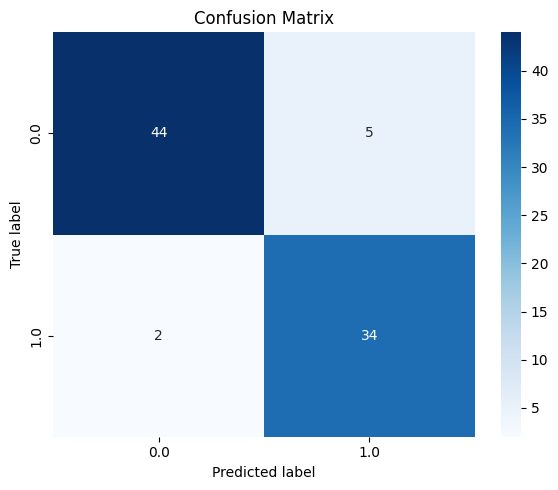


✅ Stability test finished. Results saved to: C:\Users\laura\OneDrive - Imperial College London\project 2\Coding\New models\package\flexynesis\dataset_DM_stablility_test\stability_fixed model.json
🧠 Feature importance files saved to: C:\Users\laura\OneDrive - Imperial College London\project 2\Coding\New models\package\flexynesis\dataset_DM_stablility_test\feature_importance_fixed model/
🏁 All stability tests finished in 23254.77 seconds.


In [19]:
# With 4 models
import os
import json
import pandas as pd
import numpy as np  # 加上这一行，确保np相关类型能转换
from flexynesis import HyperparameterTuning, DirectPred, DataImporter, evaluate_wrapper

def convert_np_types(obj):
    if isinstance(obj, dict):
        return {k: convert_np_types(v) for k, v in obj.items()}
    elif isinstance(obj, list):
        return [convert_np_types(i) for i in obj]
    elif isinstance(obj, (np.integer, np.int64)):
        return int(obj)
    elif isinstance(obj, (np.floating, np.float64)):
        return float(obj)
    elif isinstance(obj, pd.DataFrame):
        return convert_np_types(obj.to_dict(orient='records'))
    elif isinstance(obj, pd.Series):
        return convert_np_types(obj.to_dict())
    else:
        return obj

def run_stability_test_dict(
    test_sizes=[0.3],
    seeds=[0, 1, 2, 42, 2023],
    base_path=None,
    save_path='stability_results.json',
    importance_dir="feature_importance"
):
    results_dict = {}

    os.makedirs(importance_dir, exist_ok=True)

    for test_size in test_sizes:
        test_key = f"test_size_{test_size}"
        results_dict[test_key] = {}

        for seed in seeds:
            print(f"\n🔁 Running for test_size={test_size}, seed={seed}")
            seed_key = f"seed_{seed}"

            prepare_and_save_data(test_size=test_size, random_seed=seed, debug=False)

            data_importer = DataImporter(
                path=base_path,
                data_types=['BM','HDF','LD','PM'],
                concatenate=False,
                top_percentile=100,
                min_features=100,
                variance_threshold=0.0,
            )
            train_dataset, test_dataset, whole_dataset = data_importer.import_data()

            tuner = HyperparameterTuning(
                dataset=train_dataset,
                model_class=DirectPred,
                target_variables=["clin"],
                config_name="DirectPred",
                n_iter=60,
                cv_splits=5,
                plot_losses=False,
                early_stop_patience=7
            )
            model, best_params, configs = tuner.perform_tuning()

            y_pred_dict = model.predict(test_dataset)
            metrics_df = evaluate_wrapper(method='DirectPred', y_pred_dict=y_pred_dict, dataset=test_dataset)

            df_importance, df_importance_diff = Compute_Feature_Importance_diff(
                model=model,
                dataset=whole_dataset,
                target_var="clin",
                method="GradientShap",
                steps_or_samples=10,
                batch_size=32,
                device='cpu'
            )

            if hasattr(metrics_df, 'to_dict'):
                metrics = metrics_df.to_dict(orient='records')
            else:
                metrics = dict(metrics_df)

            results_dict[test_key][seed_key] = {
                "best_params": best_params,
                "configs": configs,
                "metrics": metrics,
                "feature_importance": df_importance.to_dict(orient='records'),
                "feature_importance_diff": df_importance_diff.to_dict(orient='records')
            }

    results_dict_clean = convert_np_types(results_dict)
    with open(save_path, 'w') as f:
        json.dump(results_dict_clean, f, indent=2)

    print(f"\n✅ Stability test finished. Results saved to: {save_path}")
    print(f"🧠 Feature importance files saved to: {importance_dir}/")

    return results_dict


# 用法示范
import time
total_start = time.time()

base_path = r"C:\Users\laura\OneDrive - Imperial College London\project 2\Coding\New models\package\flexynesis\dataset_DM_stablility_test"
save_path = os.path.join(base_path, "stability_fixed model.json")
importance_dir = os.path.join(base_path, "feature_importance_fixed model")

results_dict = run_stability_test_dict(
    test_sizes=[0.3],
    seeds=[30, 32, 42, 48, 2023, 2024,2025, 2026 ,2027,2030],
    base_path=base_path,
    save_path=save_path,
    importance_dir=importance_dir
)
total_end = time.time()
print(f"🏁 All stability tests finished in {total_end - total_start:.2f} seconds.")

In [21]:
# four models stability test
import json
import os
import pandas as pd

# ✅ 正确路径（你实际生成文件的位置）
base_path = r"C:\Users\laura\OneDrive - Imperial College London\project 2\Coding\New models\package\flexynesis\dataset_DM_stablility_test"
json_path = os.path.join(base_path, "stability_fixed model.json")

# 加载结果 JSON
with open(json_path, 'r') as f:
    results = json.load(f)

# 打印结构示例
for test_size, seeds_dict in results.items():
    print(f"\n📦 Test Size: {test_size}")
    for seed, content in seeds_dict.items():
        print(f"  🌱 Seed: {seed}")
        print(f"    - Best Params: {content['best_params']}")
        print(f"    - # of Feature Importances: {len(content['feature_importance'])}")
        print(f"    - Metrics Sample: {content['metrics'][:1]}")

# 提取所有 feature importance 到一个 DataFrame
all_importances = []
all_importance_diffs = []

for test_size, seeds_dict in results.items():
    for seed, content in seeds_dict.items():
        for fi in content['feature_importance']:
            fi['test_size'] = test_size
            fi['seed'] = seed
            all_importances.append(fi)

        for diff in content['feature_importance_diff']:
            diff['test_size'] = test_size
            diff['seed'] = seed
            all_importance_diffs.append(diff)

df_importance = pd.DataFrame(all_importances)
df_importance_diff = pd.DataFrame(all_importance_diffs)

# 显示一个 diff 的例子
print("\n🎯 Example of feature importance diff:")
if not df_importance_diff.empty:
    print(df_importance_diff.iloc[0])
    print("\n📌 Columns:", df_importance_diff.columns.tolist())
else:
    print("No feature importance diff data found.")

# 可选：保存为 CSV
# df_importance_diff.to_csv("importance_diff_all.csv", index=False)



📦 Test Size: test_size_0.3
  🌱 Seed: seed_30
    - Best Params: {'latent_dim': 66, 'hidden_dim_factor': 0.4725055218639653, 'lr': 0.0020001931131077085, 'supervisor_hidden_dim': 37, 'epochs': 23, 'batch_size': 128}
    - # of Feature Importances: 5430
    - Metrics Sample: [{'method': 'DirectPred', 'var': 'clin', 'variable_type': 'categorical', 'metric': 'balanced_acc', 'value': 0.8239202657807309}]
  🌱 Seed: seed_32
    - Best Params: {'latent_dim': 66, 'hidden_dim_factor': 0.472229773621894, 'lr': 0.0020816206214936146, 'supervisor_hidden_dim': 37, 'epochs': 19, 'batch_size': 128}
    - # of Feature Importances: 5430
    - Metrics Sample: [{'method': 'DirectPred', 'var': 'clin', 'variable_type': 'categorical', 'metric': 'balanced_acc', 'value': 0.870680044593088}]
  🌱 Seed: seed_42
    - Best Params: {'latent_dim': 66, 'hidden_dim_factor': 0.4726340752502885, 'lr': 0.0020135956917038005, 'supervisor_hidden_dim': 37, 'epochs': 39, 'batch_size': 128}
    - # of Feature Importances: 54

In [23]:
import json
import os
import pandas as pd

# 路径
base_path = r"C:\Users\laura\OneDrive - Imperial College London\project 2\Coding\New models\package\flexynesis\dataset_DM_stablility_test"
json_path = os.path.join(base_path, "stability_fixed model.json")

# 读取 JSON
with open(json_path, 'r') as f:
    results = json.load(f)

# 示例：打印结构和某些关键字段
for test_size, seeds_dict in results.items():
    print(f"\n📦 Test Size: {test_size}")
    for seed, content in seeds_dict.items():
        print(f"  🌱 Seed: {seed}")
        print(f"    - Best Params: {content['best_params']}")
        print(f"    - # of Feature Importances: {len(content['feature_importance'])}")
        print(f"    - Metrics: {content['metrics'][:1]}")  # 只打印第一个 metrics 记录

all_importances = []

for test_size, seeds_dict in results.items():
    for seed, content in seeds_dict.items():
        for fi in content['feature_importance']:
            fi['test_size'] = test_size
            fi['seed'] = seed
            all_importances.append(fi)

df_importance_diff = pd.DataFrame(all_importances)
df_importance_diff



📦 Test Size: test_size_0.3
  🌱 Seed: seed_30
    - Best Params: {'latent_dim': 66, 'hidden_dim_factor': 0.4725055218639653, 'lr': 0.0020001931131077085, 'supervisor_hidden_dim': 37, 'epochs': 23, 'batch_size': 128}
    - # of Feature Importances: 5430
    - Metrics: [{'method': 'DirectPred', 'var': 'clin', 'variable_type': 'categorical', 'metric': 'balanced_acc', 'value': 0.8239202657807309}]
  🌱 Seed: seed_32
    - Best Params: {'latent_dim': 66, 'hidden_dim_factor': 0.472229773621894, 'lr': 0.0020816206214936146, 'supervisor_hidden_dim': 37, 'epochs': 19, 'batch_size': 128}
    - # of Feature Importances: 5430
    - Metrics: [{'method': 'DirectPred', 'var': 'clin', 'variable_type': 'categorical', 'metric': 'balanced_acc', 'value': 0.870680044593088}]
  🌱 Seed: seed_42
    - Best Params: {'latent_dim': 66, 'hidden_dim_factor': 0.4726340752502885, 'lr': 0.0020135956917038005, 'supervisor_hidden_dim': 37, 'epochs': 39, 'batch_size': 128}
    - # of Feature Importances: 5430
    - Metri

,target_variable,target_class,target_class_label,layer,name,importance,test_size,seed
0,clin,0,DM,BM,BM0001_BM,-0.002179,test_size_0.3,seed_30
1,clin,0,DM,BM,BM0002_BM,-0.001464,test_size_0.3,seed_30
2,clin,0,DM,BM,BM0003_BM,0.000472,test_size_0.3,seed_30
3,clin,0,DM,BM,BM0004_BM,-0.000260,test_size_0.3,seed_30
4,clin,0,DM,BM,BM0005_BM,-0.004982,test_size_0.3,seed_30
...,...,...,...,...,...,...,...,...
54295,clin,1,nonDM,HDF,HDF62636_HDF,0.002443,test_size_0.3,seed_2030
54296,clin,1,nonDM,HDF,HDF62664_HDF,-0.000223,test_size_0.3,seed_2030
54297,clin,1,nonDM,HDF,HDF62716_HDF,-0.000095,test_size_0.3,seed_2030
54298,clin,1,nonDM,HDF,HDF62719_HDF,-0.000164,test_size_0.3,seed_2030


In [27]:
import json
import os
import pandas as pd

# 路径
base_path = r"C:\Users\laura\OneDrive - Imperial College London\project 2\Coding\New models\package\flexynesis\dataset_DM_stablility_test"
json_path = os.path.join(base_path, "stability_fixed model.json")

# 加载结果 JSON
with open(json_path, 'r') as f:
    results = json.load(f)

# 打印结构示例
for test_size, seeds_dict in results.items():
    print(f"\n📦 Test Size: {test_size}")
    for seed, content in seeds_dict.items():
        print(f"  🌱 Seed: {seed}")
        print(f"    - Best Params: {content['best_params']}")
        print(f"    - # of Feature Importances: {len(content['feature_importance'])}")
        print(f"    - Metrics Sample: {content['metrics'][:1]}")

# 提取所有 feature importance 到一个 DataFrame
all_importances = []
all_importance_diffs = []

for test_size, seeds_dict in results.items():
    for seed, content in seeds_dict.items():
        for fi in content['feature_importance']:
            fi['test_size'] = test_size
            fi['seed'] = seed
            all_importances.append(fi)

        for diff in content['feature_importance_diff']:
            diff['test_size'] = test_size
            diff['seed'] = seed
            all_importance_diffs.append(diff)

df_importance = pd.DataFrame(all_importances)
df_importance_diff = pd.DataFrame(all_importance_diffs)

# 显示一个 diff 的例子
print("\n🎯 Example of feature importance diff:")
if not df_importance_diff.empty:
    print(df_importance_diff.iloc[0])
    print("\n📌 Columns:", df_importance_diff.columns.tolist())
else:
    print("No feature importance diff data found.")

# 如果你想保存成 CSV
# df_importance_diff.to_csv("importance_diff_all.csv", index=False)



📦 Test Size: test_size_0.3
  🌱 Seed: seed_30
    - Best Params: {'latent_dim': 66, 'hidden_dim_factor': 0.4725055218639653, 'lr': 0.0020001931131077085, 'supervisor_hidden_dim': 37, 'epochs': 23, 'batch_size': 128}
    - # of Feature Importances: 5430
    - Metrics Sample: [{'method': 'DirectPred', 'var': 'clin', 'variable_type': 'categorical', 'metric': 'balanced_acc', 'value': 0.8239202657807309}]
  🌱 Seed: seed_32
    - Best Params: {'latent_dim': 66, 'hidden_dim_factor': 0.472229773621894, 'lr': 0.0020816206214936146, 'supervisor_hidden_dim': 37, 'epochs': 19, 'batch_size': 128}
    - # of Feature Importances: 5430
    - Metrics Sample: [{'method': 'DirectPred', 'var': 'clin', 'variable_type': 'categorical', 'metric': 'balanced_acc', 'value': 0.870680044593088}]
  🌱 Seed: seed_42
    - Best Params: {'latent_dim': 66, 'hidden_dim_factor': 0.4726340752502885, 'lr': 0.0020135956917038005, 'supervisor_hidden_dim': 37, 'epochs': 39, 'batch_size': 128}
    - # of Feature Importances: 54

In [29]:
param_rows = []
metric_rows = []

for test_size, seeds_dict in results.items():
    for seed, content in seeds_dict.items():
        # 提取参数
        param_row = {
            "test_size": float(test_size.split("_")[-1]),
            "seed": int(seed.split("_")[-1])
        }
        param_row.update(content["best_params"])
        param_rows.append(param_row)

        # 提取指标
        metric = content["metrics"][0] if isinstance(content["metrics"], list) else content["metrics"]
        metric_row = {
            "test_size": float(test_size.split("_")[-1]),
            "seed": int(seed.split("_")[-1])
        }
        metric_row.update(metric)
        metric_rows.append(metric_row)

df_params = pd.DataFrame(param_rows)
df_metrics = pd.DataFrame(metric_rows)


In [31]:
import pandas as pd

# 1. 提取参数的部分，和你之前一样
param_rows = []
for test_size, seeds_dict in results.items():
    for seed, content in seeds_dict.items():
        param_row = {
            "test_size": float(test_size.split("_")[-1]),
            "seed": int(seed.split("_")[-1])
        }
        param_row.update(content["best_params"])
        param_rows.append(param_row)
df_params = pd.DataFrame(param_rows)

# 2. 定义这个函数（你的metrics_long_to_wide）
def metrics_long_to_wide(results_dict):
    rows = []
    for test_size_key, seeds_dict in results_dict.items():
        test_size = float(test_size_key.split('_')[-1])
        for seed_key, content in seeds_dict.items():
            seed = int(seed_key.split('_')[-1])
            metrics = content['metrics']

            if isinstance(metrics, list):
                df_metrics = pd.DataFrame(metrics)
            else:
                df_metrics = pd.DataFrame([metrics])

            df_metrics['test_size'] = test_size
            df_metrics['seed'] = seed

            rows.append(df_metrics)

    all_metrics_df = pd.concat(rows, ignore_index=True)

    df_wide = all_metrics_df.pivot_table(
        index=['test_size', 'seed'],
        columns='metric',
        values='value'
    )

    df_wide.columns.name = None
    df_wide = df_wide.sort_index().sort_index(axis=1)

    return df_wide

# 3. 使用函数生成宽格式 df_metrics
df_metrics = metrics_long_to_wide(results)

# 4. 查看结果
print(df_params.head())
print(df_metrics.head())


   test_size  seed  latent_dim  hidden_dim_factor        lr  \
0        0.3    30          66           0.472506  0.002000   
1        0.3    32          66           0.472230  0.002082   
2        0.3    42          66           0.472634  0.002014   
3        0.3    48          66           0.472625  0.002175   
4        0.3  2023          66           0.472035  0.002057   

   supervisor_hidden_dim  epochs  batch_size  
0                     37      23         128  
1                     37      19         128  
2                     37      39         128  
3                     37      44         128  
4                     37      22         128  
                average_aupr  average_auroc  balanced_acc  f1_score     kappa  \
test_size seed                                                                  
0.3       30        0.941674       0.935770      0.823920  0.823383  0.647303   
          32        0.960230       0.955964      0.870680  0.870696  0.739917   
          42   

In [33]:
df_params

,test_size,seed,latent_dim,hidden_dim_factor,lr,supervisor_hidden_dim,epochs,batch_size
0,0.3,30,66,0.472506,0.002000,37,23,128
1,0.3,32,66,0.472230,0.002082,37,19,128
2,0.3,42,66,0.472634,0.002014,37,39,128
3,0.3,48,66,0.472625,0.002175,37,44,128
4,0.3,2023,66,0.472035,0.002057,37,22,128
5,0.3,2024,66,0.472000,0.002131,37,27,128
6,0.3,2025,66,0.472234,0.002009,37,38,128
7,0.3,2026,66,0.472000,0.002054,37,22,128
8,0.3,2027,66,0.472830,0.002034,37,21,128
9,0.3,2030,66,0.472889,0.002180,37,34,128


In [35]:
import pandas as pd

def compute_cv_by_test_size(df_params):
    # 选出要计算CV的数值参数列（排除非超参数的如 seed、test_size）
    exclude_cols = ['test_size', 'seed']
    param_cols = [col for col in df_params.columns if col not in exclude_cols]
    
    # 分组计算均值和标准差
    grouped = df_params.groupby('test_size')[param_cols]
    means = grouped.mean()
    stds = grouped.std()

    # 计算变异系数 CV = std / mean
    cv = stds / means
    cv.columns = [col + '_cv' for col in cv.columns]
    cv.reset_index(inplace=True)

    return cv
df_params_cv = compute_cv_by_test_size(df_params)
df_params_cv

,test_size,latent_dim_cv,hidden_dim_factor_cv,lr_cv,supervisor_hidden_dim_cv,epochs_cv,batch_size_cv
0,0.3,0.0,0.000723,0.032232,0.0,0.312251,0.0



📊 变异系数（CV）表格:
                                 0
test_size                 0.300000
latent_dim_cv             0.000000
hidden_dim_factor_cv      0.000723
lr_cv                     0.032232
supervisor_hidden_dim_cv  0.000000
epochs_cv                 0.312251
batch_size_cv             0.000000


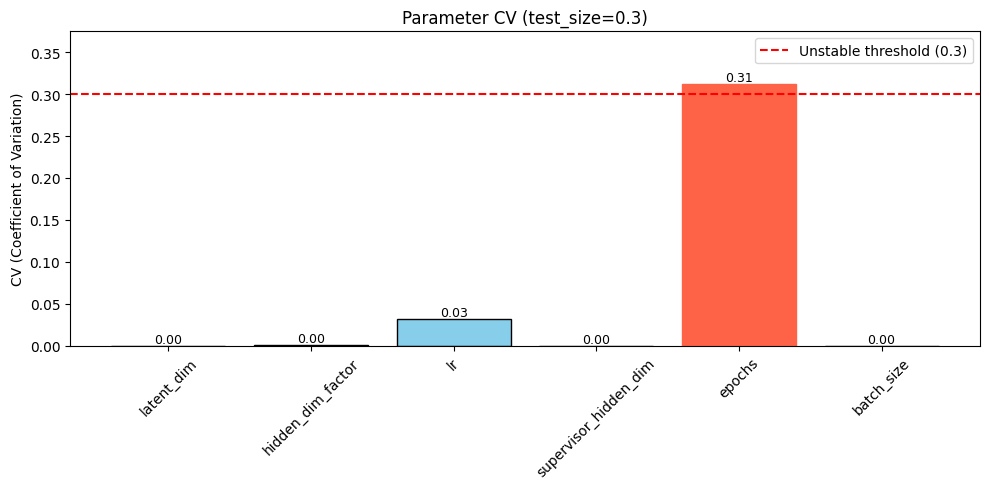

In [37]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def compute_and_plot_cv(df_params, group_col='test_size'):
    # 筛选超参数列（排除非超参数字段）
    param_cols = [col for col in df_params.columns if col not in [group_col, 'seed']]
    
    # 按 test_size 分组计算每列的CV
    stability_summary = []

    for test_size, group in df_params.groupby(group_col):
        summary = {'test_size': test_size}
        for param in param_cols:
            mean = group[param].mean()
            std = group[param].std()
            cv = std / mean if mean != 0 else np.nan
            summary[f'{param}_cv'] = cv
        stability_summary.append(summary)

    df_cv = pd.DataFrame(stability_summary)

    # 打印数值结果
    print("\n📊 变异系数（CV）表格:")
    print(df_cv.T)

    # 绘图
    for _, row in df_cv.iterrows():
        test_size = row['test_size']
        param_cvs = row.drop('test_size')
        param_names = [col.replace('_cv', '') for col in param_cvs.index]
        cv_values = param_cvs.values

        plt.figure(figsize=(10, 5))
        bars = plt.bar(param_names, cv_values, color='skyblue', edgecolor='black')
        
        # 标出不稳定（CV > 0.3）参数
        for bar, val in zip(bars, cv_values):
            if val > 0.3:
                bar.set_color('tomato')
            plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(), f'{val:.2f}', 
                     ha='center', va='bottom', fontsize=9)

        plt.title(f'Parameter CV (test_size={test_size})')
        plt.ylabel('CV (Coefficient of Variation)')
        plt.xticks(rotation=45)
        plt.ylim(0, max(cv_values)*1.2)
        plt.axhline(0.3, color='red', linestyle='--', label='Unstable threshold (0.3)')
        plt.legend()
        plt.tight_layout()
        plt.show()

    return df_cv

# 🔧 用你的 df_params 调用函数：
df_cv = compute_and_plot_cv(df_params)


In [39]:
df_metrics

average_aupr  average_auroc  balanced_acc  f1_score     kappa  \
test_size seed                                                                  
0.3       30        0.941674       0.935770      0.823920  0.823383  0.647303   
          32        0.960230       0.955964      0.870680  0.870696  0.739917   
          42        0.956495       0.963768      0.890468  0.893672  0.785534   
          48        0.895038       0.906912      0.830268  0.834274  0.665730   
          2023      0.901746       0.915836      0.858250  0.858431  0.717295   
          2024      0.961346       0.959579      0.870432  0.870552  0.741069   
          2025      0.905116       0.911667      0.837500  0.835385  0.671271   
          2026      0.945023       0.942778      0.848611  0.847186  0.694329   
          2027      0.890795       0.910853      0.812846  0.810296  0.624309   
          2030      0.963667       0.972222      0.921202  0.917994  0.833193   

                precision    recall  
test_size seed                       
0.3       30     0.825294  0.823529  
          32     0.871046  0.870588  
          42     0.895498  0.894118  
          48     0.837042  0.835294  
          2023   0.861880  0.858824  
          2024   0.870758  0.870588  
          2025   0.839181  0.835294  
          2026   0.849423  0.847059  
          2027   0.823597  0.811765  
          2030   0.920637  0.917647

In [45]:
import pandas as pd

def metrics_long_to_wide(results_dict):
    rows = []

    # 遍历结果收集所有metrics的长表数据
    for test_size_key, seeds_dict in results_dict.items():
        test_size = float(test_size_key.split('_')[-1])
        for seed_key, content in seeds_dict.items():
            seed = int(seed_key.split('_')[-1])
            metrics = content['metrics']

            # metrics是list（长格式的DataFrame转dict的records），转成DataFrame
            if isinstance(metrics, list):
                df_metrics = pd.DataFrame(metrics)
            else:
                df_metrics = pd.DataFrame([metrics])

            # 添加test_size和seed列
            df_metrics['test_size'] = test_size
            df_metrics['seed'] = seed

            rows.append(df_metrics)

    # 合并所有seed的数据
    all_metrics_df = pd.concat(rows, ignore_index=True)

    # 转成宽格式，行是 (test_size, seed)，列是metric，值是value
    df_wide = all_metrics_df.pivot_table(
        index=['test_size', 'seed'],
        columns='metric',
        values='value'
    )

    # 如果需要，去掉columns名字，变成普通列名
    df_wide.columns.name = None

    # 排序
    df_wide = df_wide.sort_index().sort_index(axis=1)

    return df_wide


# 使用示例
df_metrics = metrics_long_to_wide(results_dict)
df_metrics



average_aupr  average_auroc  balanced_acc  f1_score     kappa  \
test_size seed                                                                  
0.3       30        0.941674       0.935770      0.823920  0.823383  0.647303   
          32        0.960230       0.955964      0.870680  0.870696  0.739917   
          42        0.956495       0.963768      0.890468  0.893672  0.785534   
          48        0.895038       0.906912      0.830268  0.834274  0.665730   
          2023      0.901746       0.915836      0.858250  0.858431  0.717295   
          2024      0.961346       0.959579      0.870432  0.870552  0.741069   
          2025      0.905116       0.911667      0.837500  0.835385  0.671271   
          2026      0.945023       0.942778      0.848611  0.847186  0.694329   
          2027      0.890795       0.910853      0.812846  0.810296  0.624309   
          2030      0.963667       0.972222      0.921202  0.917994  0.833193   

                precision    recall  
test_size seed                       
0.3       30     0.825294  0.823529  
          32     0.871046  0.870588  
          42     0.895498  0.894118  
          48     0.837042  0.835294  
          2023   0.861880  0.858824  
          2024   0.870758  0.870588  
          2025   0.839181  0.835294  
          2026   0.849423  0.847059  
          2027   0.823597  0.811765  
          2030   0.920637  0.917647

In [47]:
def calc_stats_df_transposed(df, test_size):
    subset = df.loc[test_size]
    means = subset.mean()
    stds = subset.std()
    cv = stds / means

    stats_df = pd.DataFrame({
        'mean': means,
        'std': stds,
        'cv': cv
    }).T  # 转置

    return stats_df

df_stats_0_3 = calc_stats_df_transposed(df_metrics, 0.3)



print("\nStats for test_size=0.3:")
df_stats_0_3



Stats for test_size=0.3:


,average_aupr,average_auroc,balanced_acc,f1_score,kappa,precision,recall
mean,0.932113,0.937535,0.856418,0.856187,0.711995,0.859436,0.856471
std,0.030233,0.024804,0.033027,0.033037,0.064751,0.031229,0.032716
cv,0.032434,0.026457,0.038564,0.038587,0.090944,0.036336,0.038199


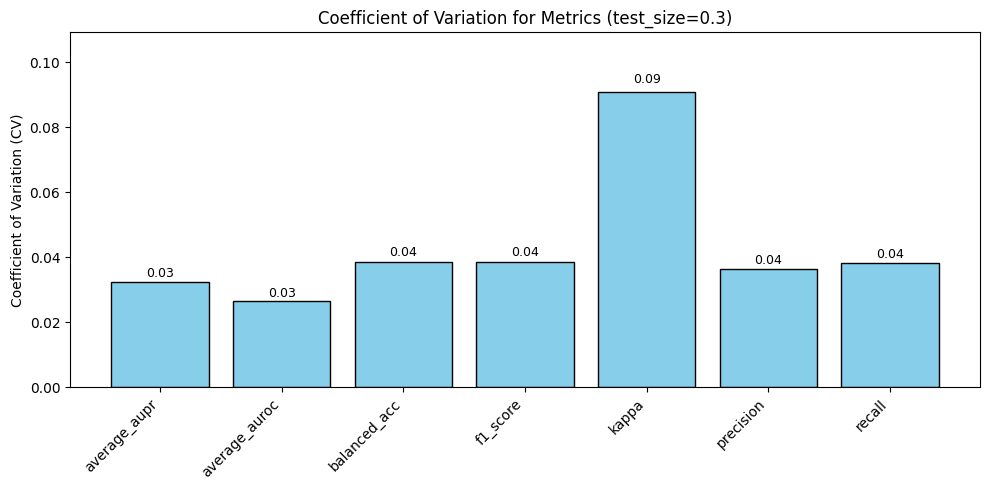

In [49]:
import matplotlib.pyplot as plt
import numpy as np

def plot_cv_bar(stats_df, test_size):
    cv_values = stats_df.loc['cv']
    metrics = cv_values.index

    plt.figure(figsize=(10, 5))
    bars = plt.bar(metrics, cv_values, color='skyblue', edgecolor='black')
    plt.xticks(rotation=45, ha='right')
    plt.ylabel('Coefficient of Variation (CV)')
    plt.title(f'Coefficient of Variation for Metrics (test_size={test_size})')
    plt.ylim(0, max(cv_values)*1.2)

    # 标注数值
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, height * 1.02, f'{height:.2f}', ha='center', va='bottom', fontsize=9)

    plt.tight_layout()
    plt.show()

plot_cv_bar(df_stats_0_3, 0.3)

In [51]:
import pandas as pd

def extract_all_losses_from_configs(results_dict):
    rows = []
    for test_size_key, seeds_dict in results_dict.items():
        test_size = float(test_size_key.split('_')[-1])
        for seed_key, content in seeds_dict.items():
            seed = int(seed_key.split('_')[-1])
            configs = content.get('configs', None)

            if configs is not None:
                if isinstance(configs, list):
                    df_configs = pd.DataFrame(configs)
                elif isinstance(configs, pd.DataFrame):
                    df_configs = configs
                else:
                    df_configs = None

                if df_configs is not None and 'loss' in df_configs.columns and not df_configs.empty:
                    # 给每一行加上 test_size 和 seed
                    df_configs = df_configs.copy()
                    df_configs['test_size'] = test_size
                    df_configs['seed'] = seed

                    # 只保留你关心的列，比如loss，iter，和测试参数
                    # 你也可以保留更多列，这里以loss和iter为例
                    cols_to_keep = ['test_size', 'seed', 'loss', 'iter']
                    existing_cols = [c for c in cols_to_keep if c in df_configs.columns]
                    df_configs = df_configs[existing_cols]

                    # 加入结果集
                    rows.append(df_configs)

    if rows:
        df_loss_all = pd.concat(rows, ignore_index=True)
    else:
        df_loss_all = pd.DataFrame()

    return df_loss_all

# 用法示范
df_all_losses = extract_all_losses_from_configs(results_dict)
print(df_all_losses.head())

import os

# 保存目录
save_dir = r"C:\Users\laura\OneDrive - Imperial College London\project 2\Coding\New models\package\flexynesis\dataset_DM_stablility_test"
os.makedirs(save_dir, exist_ok=True)

# 保存路径
losses_path = os.path.join(save_dir, "df_all_losses_stability.csv")

# 保存 DataFrame
df_all_losses.to_csv(losses_path, index=False)

print(f"✅ df_all_losses 已保存至：{losses_path}")


   test_size  seed      loss  iter
0        0.3    30  0.397673     1
1        0.3    30  0.713514     2
2        0.3    30  0.681287     3
3        0.3    30  0.718542     4
4        0.3    30  0.428635     5
✅ df_all_losses 已保存至：C:\Users\laura\OneDrive - Imperial College London\project 2\Coding\New models\package\flexynesis\dataset_DM_stablility_test\df_all_losses_stability.csv


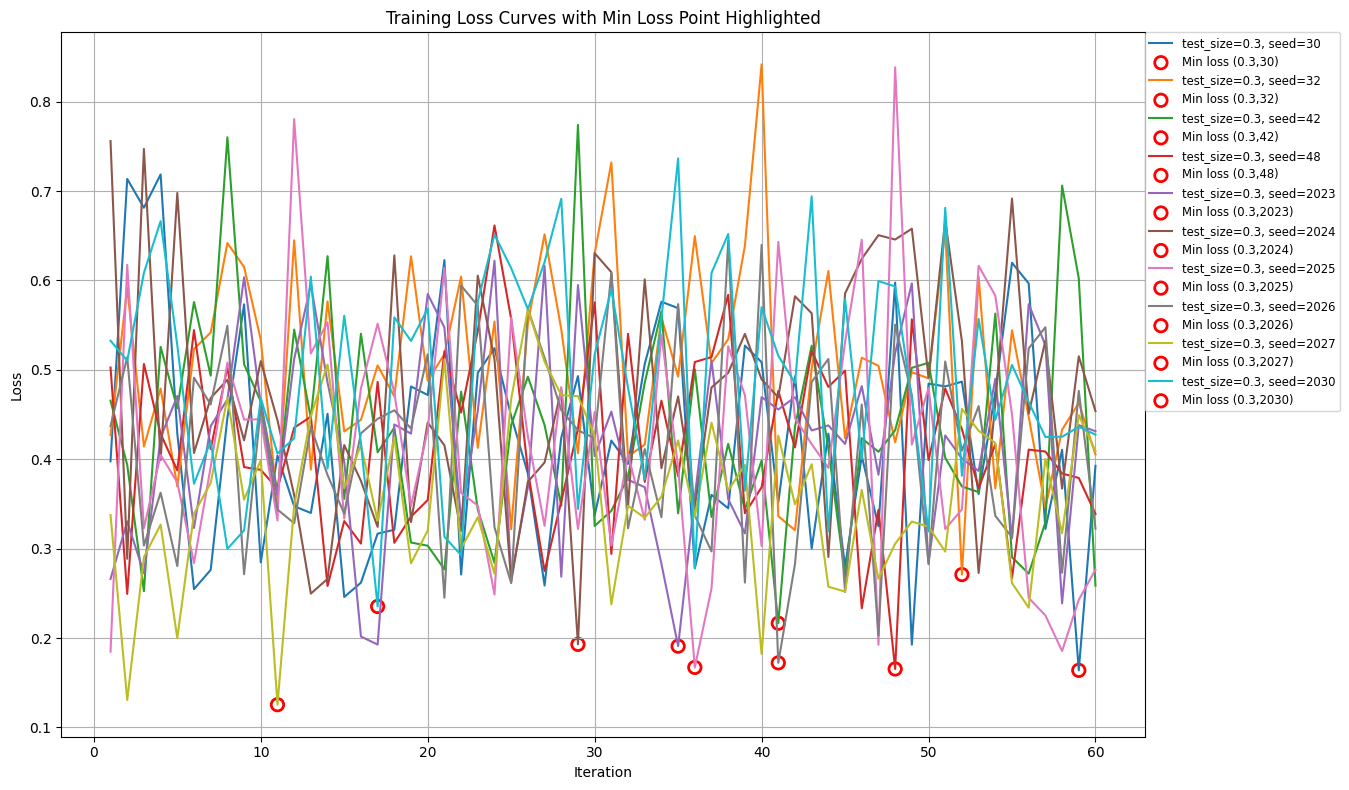

In [53]:
import matplotlib.pyplot as plt

def plot_loss_curves_min_point(df_losses):
    plt.figure(figsize=(16, 8))
    
    groups = df_losses.groupby(['test_size', 'seed'])
    
    for (test_size, seed), group in groups:
        group = group.sort_values('iter')
        plt.plot(group['iter'], group['loss'], label=f'test_size={test_size}, seed={seed}')
        
        min_idx = group['loss'].idxmin()
        min_point = group.loc[min_idx]
        plt.scatter(
            min_point['iter'],
            min_point['loss'],
            s=80,
            edgecolors='red',
            facecolors='none',
            linewidths=2,
            label=f'Min loss ({test_size},{seed})'
        )
    
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.title('Training Loss Curves with Min Loss Point Highlighted')
    plt.legend(
        loc='upper left',
        bbox_to_anchor=(1, 1),
        fontsize='small',
        borderaxespad=0.,
        ncol=1
    )
    plt.tight_layout(rect=[0, 0, 0.85, 1])
    plt.grid(True)
    plt.show()
plot_loss_curves_min_point(df_all_losses)


In [55]:
#特征选择稳定性
import numpy as np
import pandas as pd
from scipy.stats import spearmanr
from itertools import combinations

def kuncheva_index(set1, set2, n_features):
    k = len(set1)
    intersection = len(set1.intersection(set2))
    expected = (k ** 2) / n_features
    denom = k - expected
    if denom == 0:
        return np.nan  # 避免除0
    return (intersection - expected) / denom

def calculate_stability(results_dict, top_k=20):
    stability_results = {}

    for test_size, seeds_dict in results_dict.items():
        # 收集每个seed对应的前top_k特征
        feature_rankings = {}
        all_features = set()

        for seed, content in seeds_dict.items():
            fi_diff = content['feature_importance_diff']
            # 按importance_diff_abs排序，取前top_k特征名
            sorted_feats = sorted(fi_diff, key=lambda x: x['importance_diff_abs'], reverse=True)
            top_features = [f['name'] for f in sorted_feats[:top_k]]
            feature_rankings[seed] = top_features
            all_features.update(top_features)

        n_features = len(set(f['name'] for s in seeds_dict.values() for f in s['feature_importance_diff']))

        # 计算Spearman秩相关系数均值
        spearman_vals = []
        kuncheva_vals = []

        seeds_list = list(feature_rankings.keys())
        for s1, s2 in combinations(seeds_list, 2):
            list1 = feature_rankings[s1]
            list2 = feature_rankings[s2]

            # 对Spearman，构造两组排名向量，缺失特征排名补为max_rank+1
            all_feats_union = list(set(list1) | set(list2))
            max_rank = top_k + 1

            rank1 = [list1.index(f) + 1 if f in list1 else max_rank for f in all_feats_union]
            rank2 = [list2.index(f) + 1 if f in list2 else max_rank for f in all_feats_union]

            corr, _ = spearmanr(rank1, rank2)
            if not np.isnan(corr):
                spearman_vals.append(corr)

            # Kuncheva指标，输入为集合
            set1 = set(list1)
            set2 = set(list2)
            k_index = kuncheva_index(set1, set2, n_features)
            if not np.isnan(k_index):
                kuncheva_vals.append(k_index)

        stability_results[test_size] = {
            'mean_spearman': np.mean(spearman_vals) if spearman_vals else np.nan,
            'mean_kuncheva': np.mean(kuncheva_vals) if kuncheva_vals else np.nan,
            'spearman_values': spearman_vals,
            'kuncheva_values': kuncheva_vals,
            'n_features_total': n_features,
            'top_k': top_k
        }

    return stability_results

# 假设你已有results_dict是run_stability_test_dict返回的结果
stability = calculate_stability(results_dict, top_k=10)

for ts, vals in stability.items():
    print(f"Test Size: {ts}")
    print(f"  Mean Spearman rank correlation: {vals['mean_spearman']:.4f}")
    print(f"  Mean Kuncheva stability index: {vals['mean_kuncheva']:.4f}")
    print()


Test Size: test_size_0.3
  Mean Spearman rank correlation: -0.7769
  Mean Kuncheva stability index: 0.0677



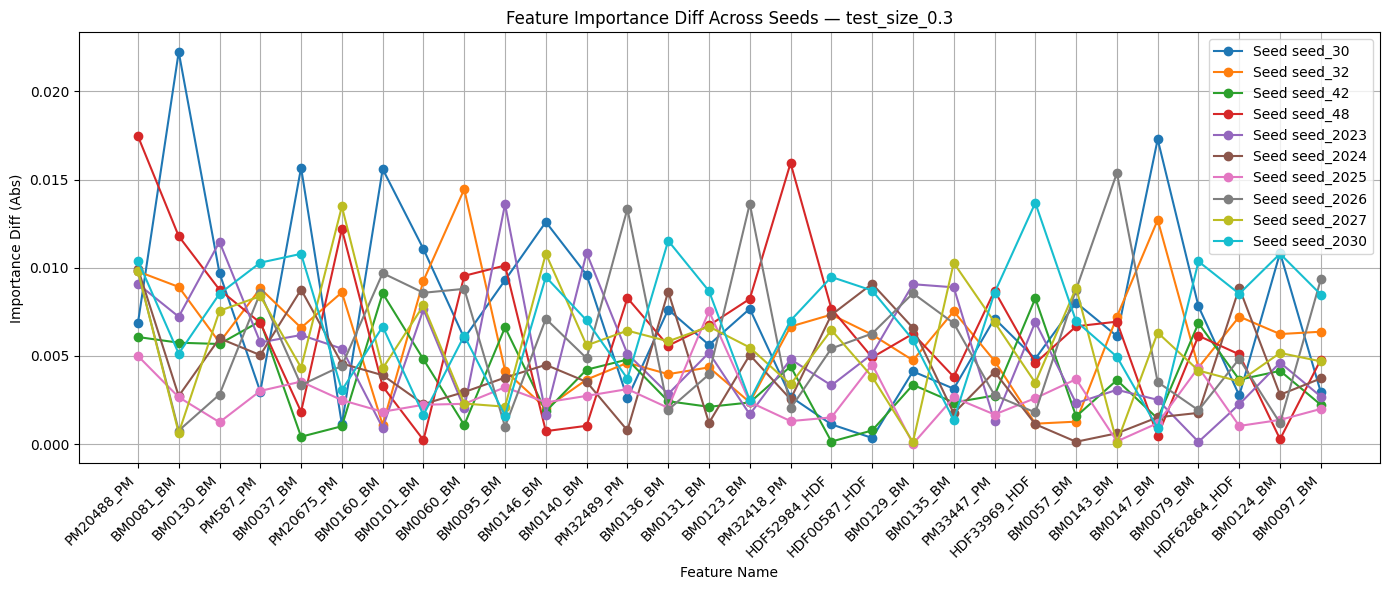

In [57]:
import matplotlib.pyplot as plt

def plot_feature_importance_diff_lines(results_dict, test_size='test_size_0.3', top_k=30):
    seed_dict = results_dict[test_size]

    # 获取所有种子的 feature importance diff，并汇总到字典里
    feature_names = set()
    seed_importance = {}

    for seed, content in seed_dict.items():
        fi_diff = content['feature_importance_diff']
        seed_importance[seed] = {f['name']: f['importance_diff_abs'] for f in fi_diff}
        feature_names.update(seed_importance[seed].keys())

    # 统一的 feature 名单
    feature_names = sorted(feature_names)
    
    # 若设置了 top_k，则只保留重要性平均最高的 top_k 特征
    if top_k:
        # 计算每个特征 across seeds 的平均 importance
        mean_importance = {}
        for feat in feature_names:
            vals = [seed_importance[seed].get(feat, 0) for seed in seed_importance]
            mean_importance[feat] = np.mean(vals)
        feature_names = sorted(mean_importance, key=mean_importance.get, reverse=True)[:top_k]

    x_labels = feature_names
    x_indices = range(len(x_labels))

    # 开始绘图
    plt.figure(figsize=(14, 6))
    for seed, feat_dict in seed_importance.items():
        y_values = [feat_dict.get(name, 0) for name in x_labels]
        plt.plot(x_indices, y_values, label=f'Seed {seed}', marker='o')

    plt.xticks(ticks=x_indices, labels=x_labels, rotation=45, ha='right')
    plt.xlabel("Feature Name")
    plt.ylabel("Importance Diff (Abs)")
    plt.title(f"Feature Importance Diff Across Seeds — {test_size}")
    plt.legend()
    plt.tight_layout()
    plt.grid(True)
    plt.show()
plot_feature_importance_diff_lines(results_dict, test_size='test_size_0.3')


In [59]:
import pandas as pd
import numpy as np

def get_feature_importance_df(results_dict, test_size='test_size_0.3', top_k=30):
    seed_dict = results_dict[test_size]

    # 收集每个 seed 的 importance
    seed_importance = {}
    feature_names = set()

    for seed, content in seed_dict.items():
        fi_diff = content['feature_importance_diff']
        seed_importance[seed] = {f['name']: f['importance_diff_abs'] for f in fi_diff}
        feature_names.update(seed_importance[seed].keys())

    feature_names = sorted(feature_names)

    # 计算所有特征的平均 importance
    mean_importance = {}
    for feat in feature_names:
        vals = [seed_importance[seed].get(feat, 0) for seed in seed_importance]
        mean_importance[feat] = np.mean(vals)

    # 筛选 top_k 特征
    selected_features = sorted(mean_importance, key=mean_importance.get, reverse=True)[:top_k]

    # 构造 DataFrame：行是特征名，列是 seed
    feature_df = pd.DataFrame(index=selected_features)

    for seed in seed_importance:
        feature_df[f'Seed_{seed}'] = [seed_importance[seed].get(feat, 0) for feat in selected_features]

    # 添加平均值列
    feature_df['mean_importance'] = feature_df.mean(axis=1)

    return feature_df

# ✅ 调用函数获取表格
feature_df = get_feature_importance_df(results_dict, test_size='test_size_0.3', top_k=30)

# ✅ 打印前几行看看
print(feature_df.head())


            Seed_seed_30  Seed_seed_32  Seed_seed_42  Seed_seed_48  \
PM20488_PM      0.006863      0.009791      0.006075      0.017462   
BM0081_BM       0.022235      0.008914      0.005752      0.011789   
BM0130_BM       0.009696      0.005767      0.005679      0.008755   
PM587_PM        0.002978      0.008826      0.006975      0.006877   
BM0037_BM       0.015673      0.006598      0.000422      0.001836   

            Seed_seed_2023  Seed_seed_2024  Seed_seed_2025  Seed_seed_2026  \
PM20488_PM        0.009082        0.009950        0.005000        0.009807   
BM0081_BM         0.007225        0.002730        0.002664        0.000769   
BM0130_BM         0.011468        0.005999        0.001244        0.002813   
PM587_PM          0.005770        0.005049        0.003019        0.008578   
BM0037_BM         0.006186        0.008763        0.003547        0.003347   

            Seed_seed_2027  Seed_seed_2030  mean_importance  
PM20488_PM        0.009817        0.010404      

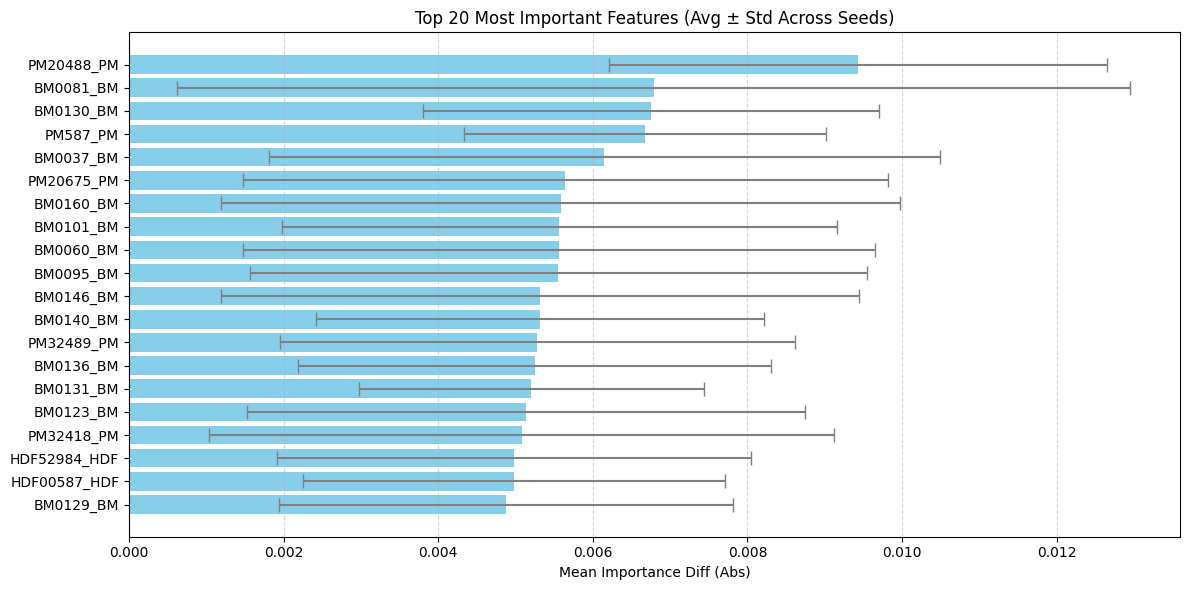

In [61]:
import pandas as pd
import matplotlib.pyplot as plt

# 假设你的原始 DataFrame 是 feature_df，行是特征，列是各个 seed
# 1. 计算 mean 和 std
mean_vals = feature_df.mean(axis=1)
std_vals = feature_df.std(axis=1)

# 2. 取前 20 个平均值最大的特征
top20 = mean_vals.nlargest(20)
top20_std = std_vals[top20.index]

# 3. 画柱状图（带误差棒）
plt.figure(figsize=(12, 6))
plt.barh(
    y=top20.index[::-1],  # 反转顺序从上大下小
    width=top20.values[::-1],
    xerr=top20_std.values[::-1],
    color='skyblue',
    ecolor='gray',
    capsize=5
)

plt.xlabel("Mean Importance Diff (Abs)")
plt.title("Top 20 Most Important Features (Avg ± Std Across Seeds)")
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


In [ ]:
# 朝参属选择

   test_size  seed  average_aupr  average_auroc  balanced_acc  f1_score  \
0        0.3     0      0.937199       0.924749      0.836120  0.835523   
1        0.3     1      0.898581       0.890798      0.808204  0.809433   
2        0.3     2      0.910616       0.923503      0.856984  0.858273   
3        0.3     5      0.918262       0.935811      0.844876  0.835842   
4        0.3    10      0.898845       0.914894      0.817189  0.812234   

      kappa  precision    recall  latent_dim  hidden_dim_factor        lr  \
0  0.669628   0.836677  0.835294          23           0.285579  0.000174   
1  0.620536   0.822076  0.811765          97           0.348506  0.000502   
2  0.716352   0.861579  0.858824          60           0.360204  0.003286   
3  0.673077   0.851242  0.835294         102           0.481026  0.004195   
4  0.624931   0.820803  0.811765          45           0.258649  0.005331   

   supervisor_hidden_dim  epochs  batch_size  
0                     29     150       

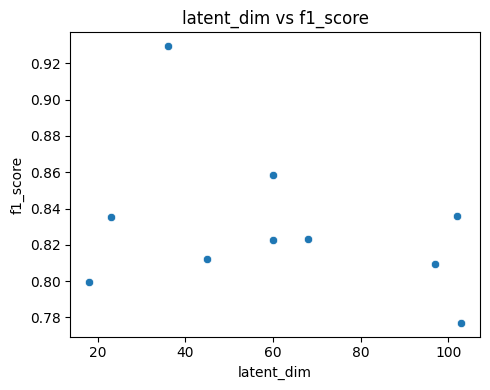

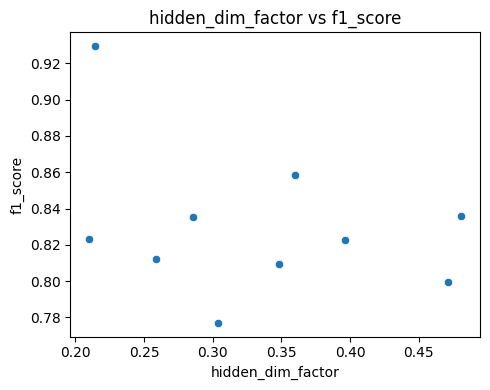

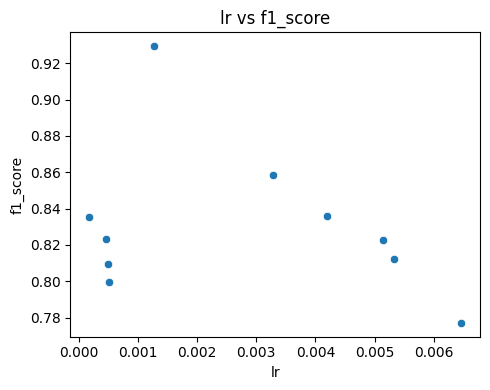

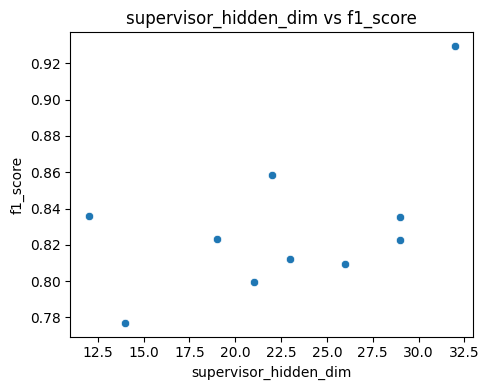

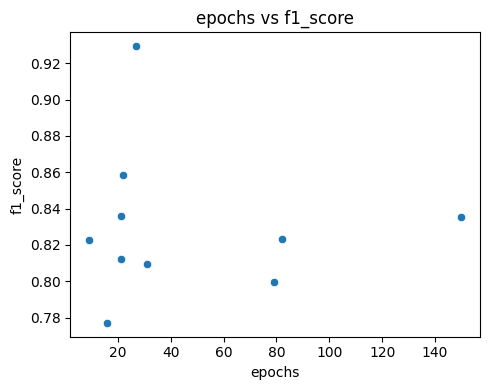

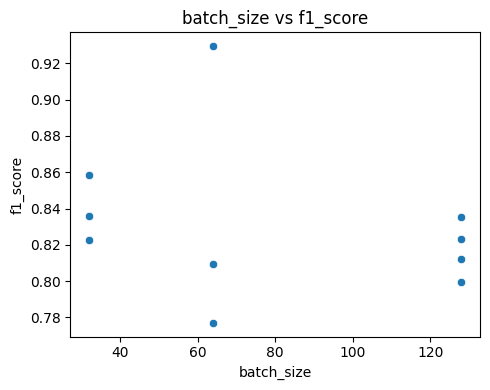

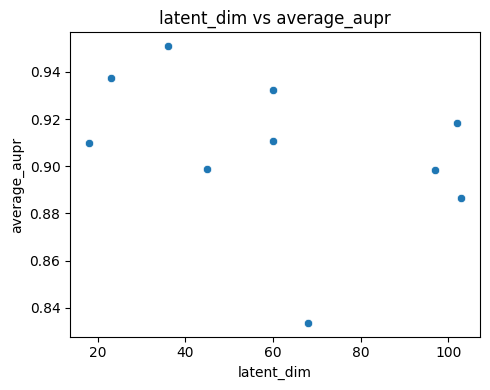

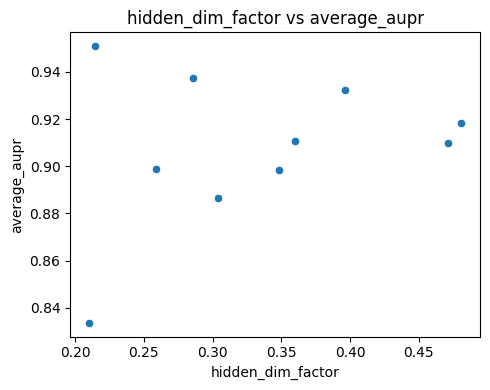

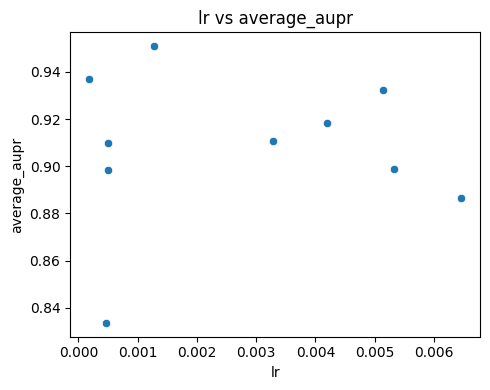

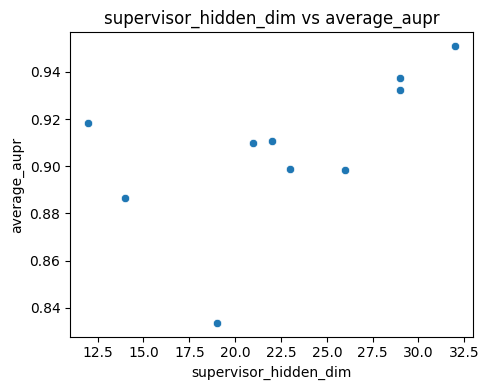

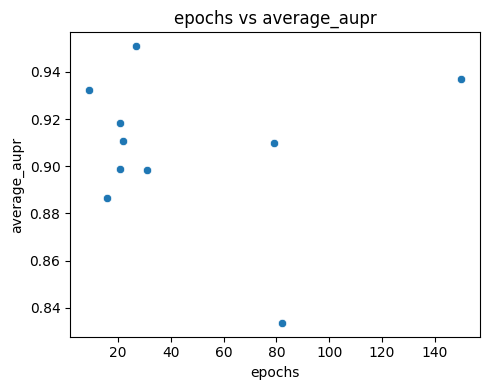

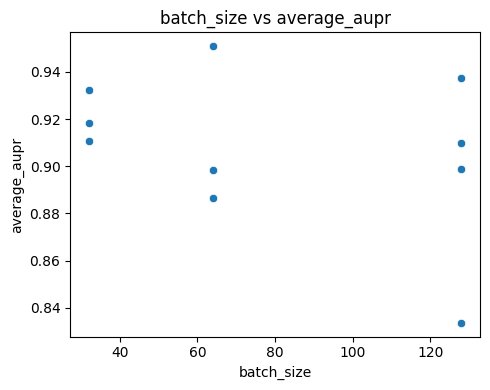

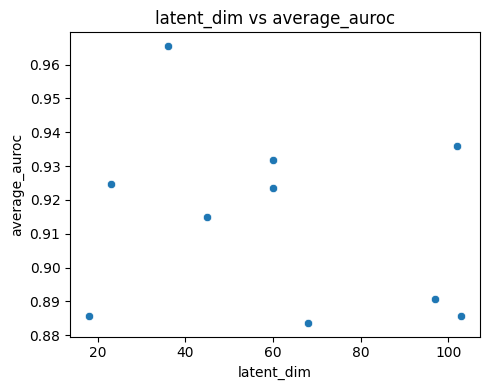

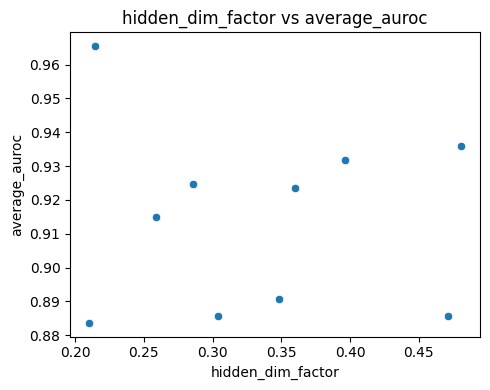

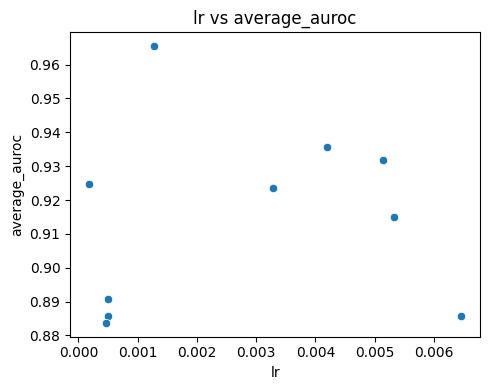

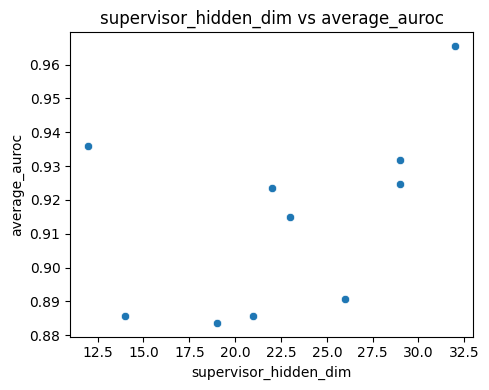

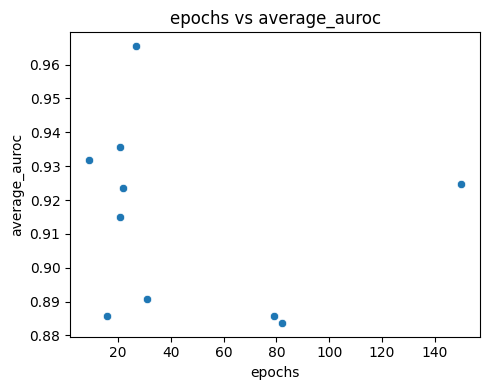

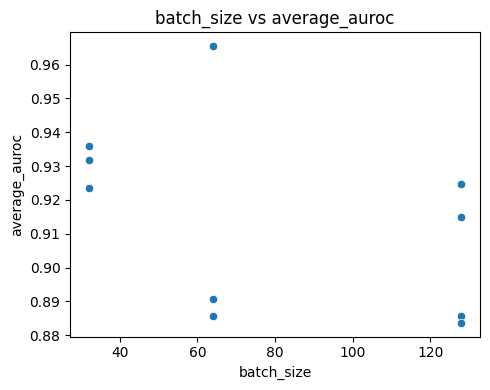

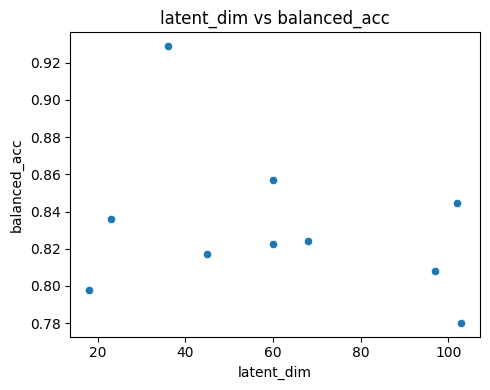

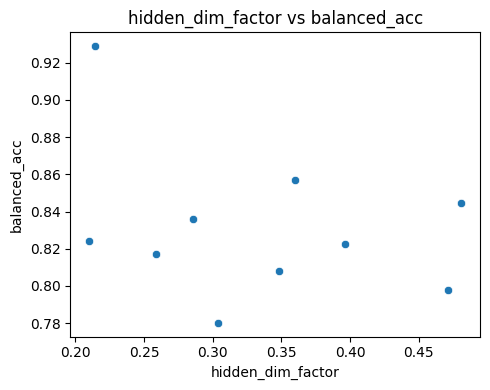

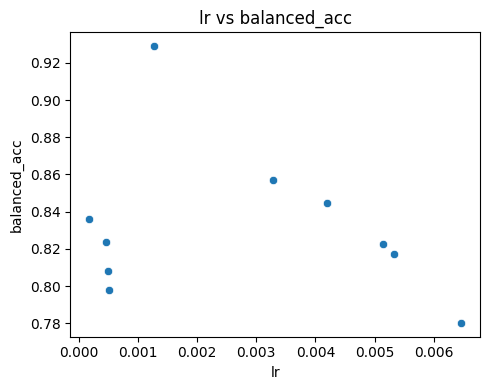

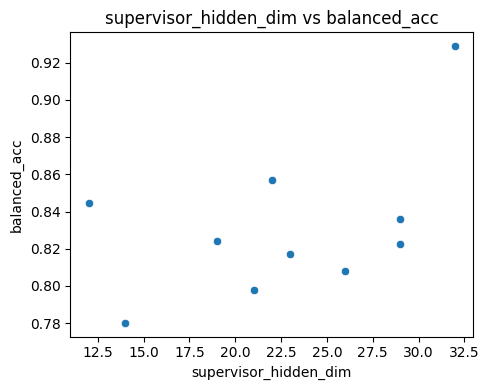

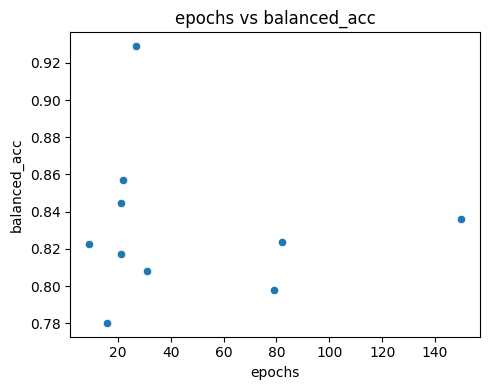

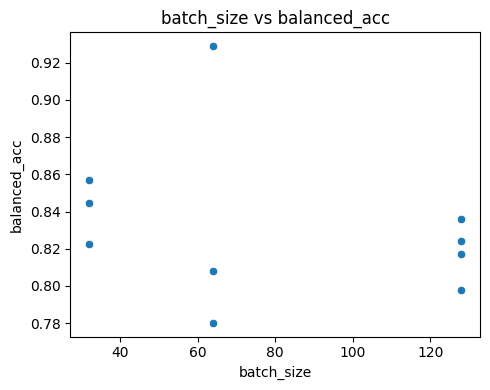

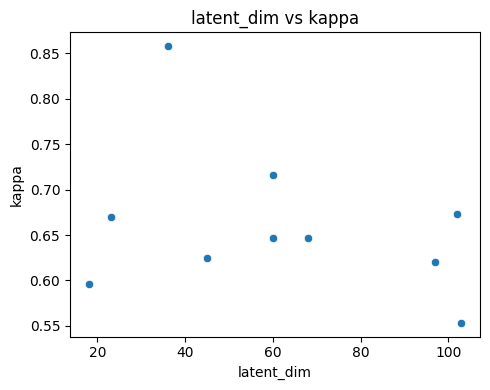

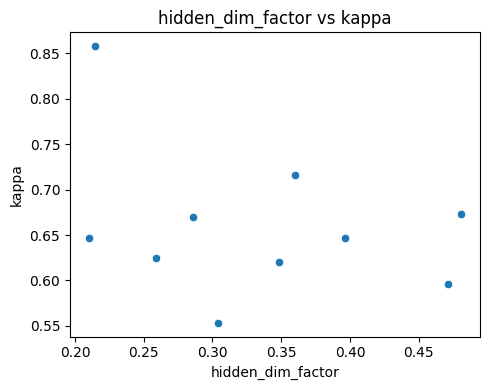

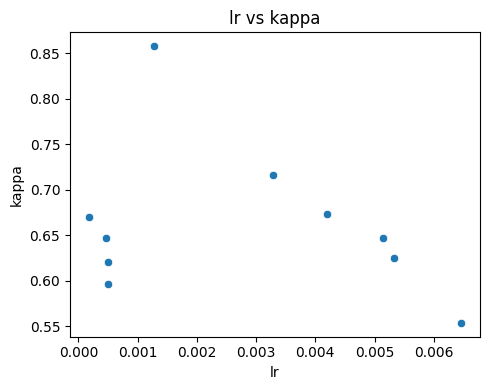

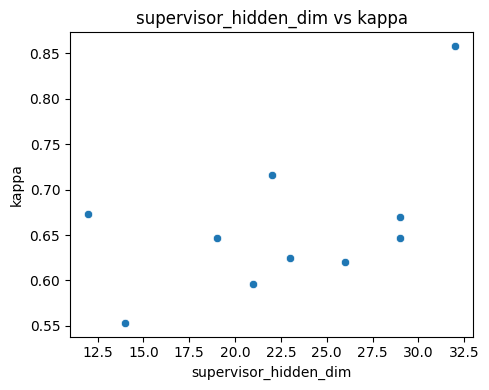

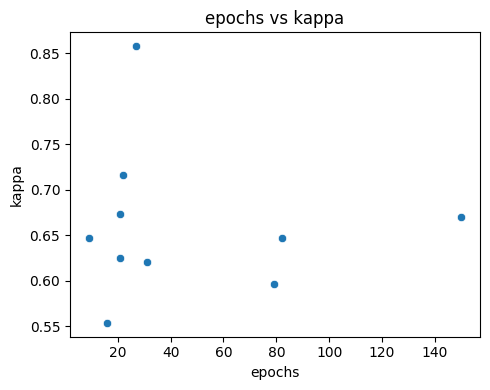

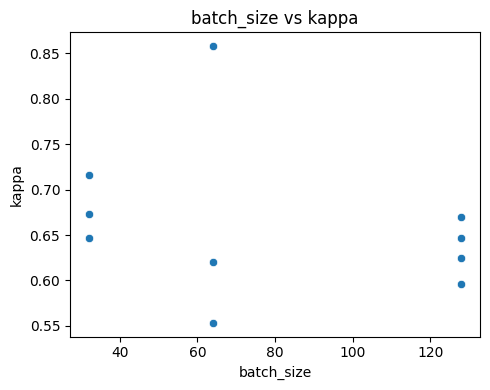

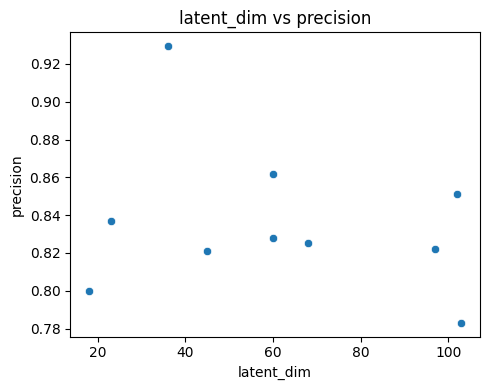

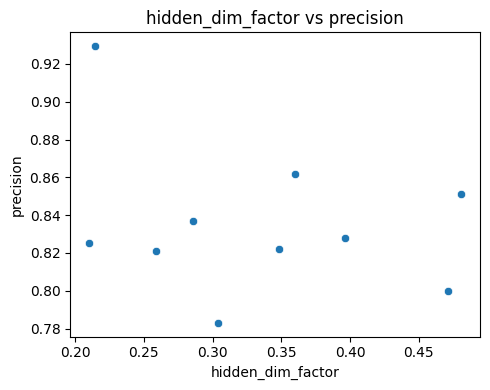

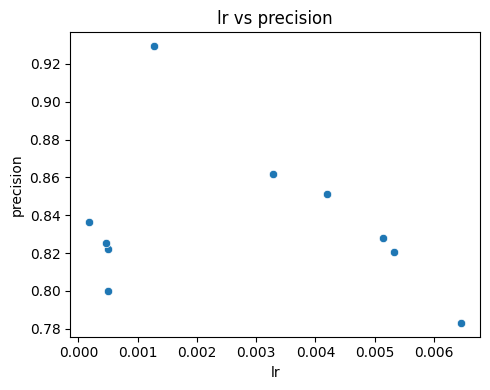

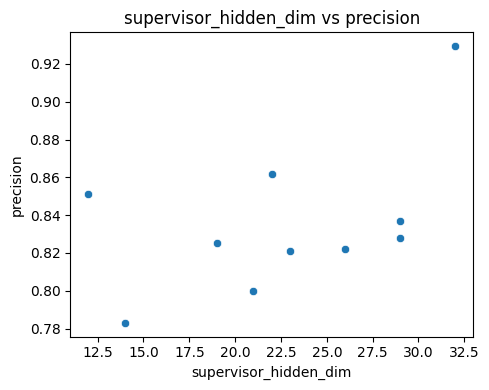

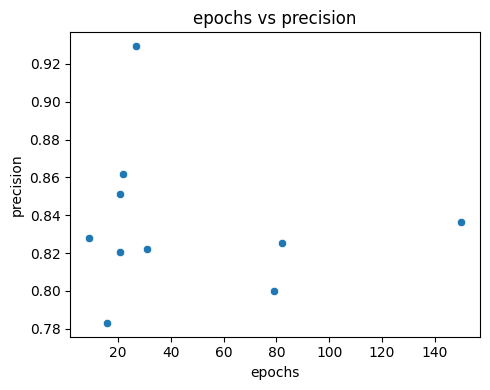

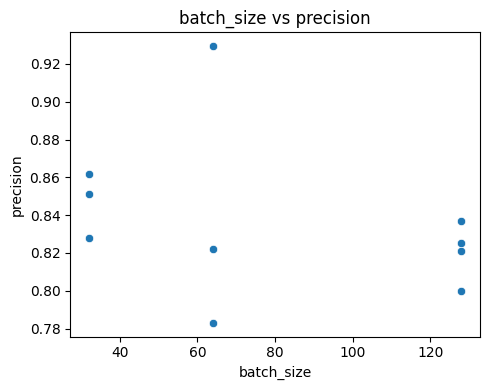

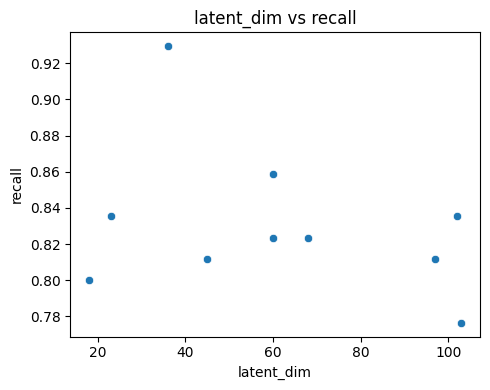

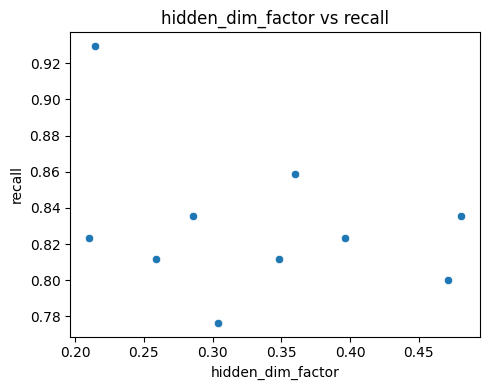

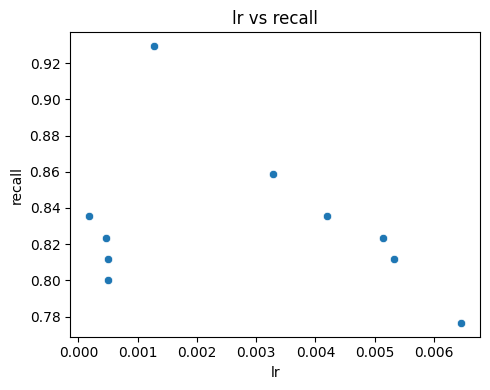

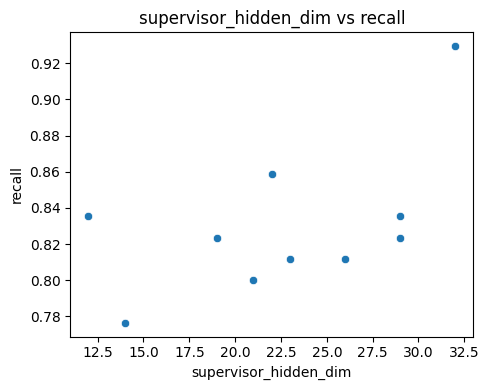

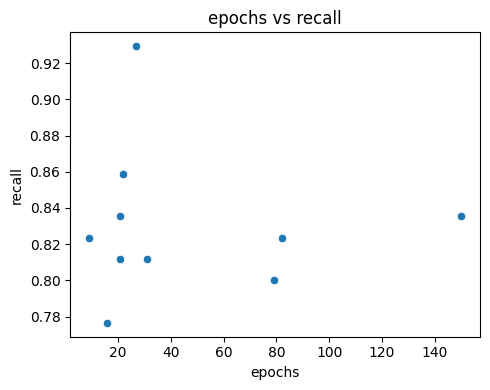

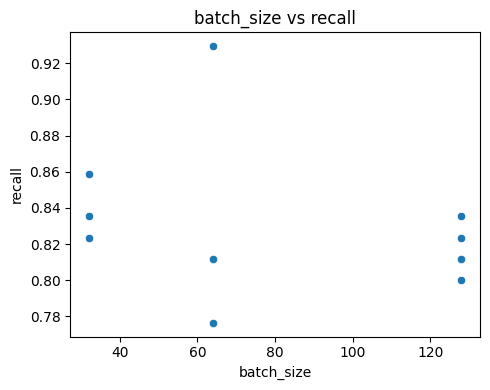

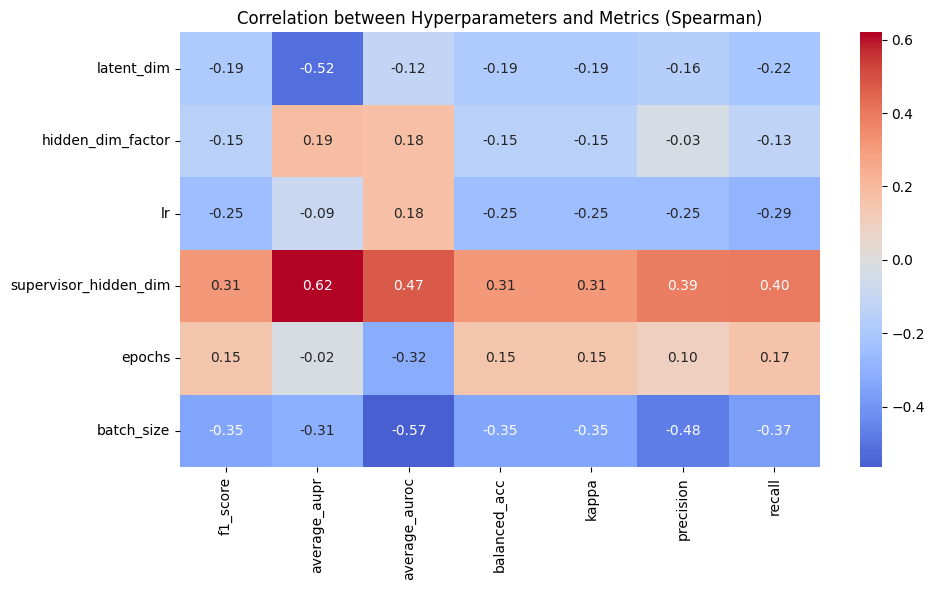

In [89]:
# Not make sense - inactive
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 假设 df_metrics 是 MultiIndex，先重置索引
df_metrics_reset = df_metrics.reset_index()

# 只保留 df_params 中不重复的参数列（避免 test_size 和 seed 重复）
df_combined = pd.concat([
    df_metrics_reset,
    df_params.drop(columns=["test_size", "seed"])
], axis=1)

# 可选：查看合并后的数据结构
print(df_combined.head())

# -----------------------------
# 1️⃣ 画散点图：每个超参数 vs 每个性能指标
# -----------------------------

metrics = ['f1_score', 'average_aupr', 'average_auroc', 'balanced_acc', 'kappa', 'precision', 'recall']
params = ['latent_dim', 'hidden_dim_factor', 'lr', 'supervisor_hidden_dim', 'epochs', 'batch_size']

# -----------------------------
# 2️⃣ 画相关性热图（Spearman 更适合非线性）
# -----------------------------

# 只保留相关列
corr_df = df_combined[params + metrics]

# 计算相关性
corr = corr_df.corr(method='spearman')

# 画热图（行是超参数，列是性能指标）
plt.figure(figsize=(10, 6))
sns.heatmap(corr.loc[params, metrics], annot=True, cmap='coolwarm', center=0, fmt=".2f")
plt.title("Correlation between Hyperparameters and Metrics (Spearman)")
plt.tight_layout()
plt.show()


In [95]:
# generate the whole config table through all runs
import pandas as pd

def extract_all_losses_with_configs(results_dict):
    rows = []
    
    for test_size_key, seeds_dict in results_dict.items():
        test_size = float(test_size_key.split('_')[-1])
        
        for seed_key, content in seeds_dict.items():
            seed = int(seed_key.split('_')[-1])
            configs = content.get('configs', None)

            if configs is not None:
                if isinstance(configs, list):
                    df_configs = pd.DataFrame(configs)
                elif isinstance(configs, pd.DataFrame):
                    df_configs = configs.copy()
                else:
                    continue  # skip invalid configs

                if 'loss' not in df_configs.columns:
                    continue

                df_configs = df_configs.copy()
                df_configs['test_size'] = test_size
                df_configs['seed'] = seed

                # 只调整列顺序，把 meta 信息放前面
                meta_cols = ['test_size', 'seed', 'loss', 'iter']
                all_cols = meta_cols + [col for col in df_configs.columns if col not in meta_cols]
                df_configs = df_configs[all_cols]

                rows.append(df_configs)

    if rows:
        df_full = pd.concat(rows, ignore_index=True)
    else:
        df_full = pd.DataFrame()

    return df_full

# ✅ 用法示范
df_all_configs_with_loss = extract_all_losses_with_configs(results)
print(df_all_configs_with_loss.head())

import os
import pandas as pd

# 假设你已经有了 df_all_configs_with_loss
# 保存目录
save_dir = r"C:\Users\laura\OneDrive - Imperial College London\project 2\Coding\New models\package\flexynesis\dataset_DM_stablility_test"
os.makedirs(save_dir, exist_ok=True)

# 保存路径
save_path = os.path.join(save_dir, "df_all_configs_with_loss.csv")

# 保存 DataFrame
df_all_configs_with_loss.to_csv(save_path, index=False)
print(f"✅ DataFrame 已保存至: {save_path}")


   test_size  seed      loss  iter  latent_dim  hidden_dim_factor        lr  \
0        0.3     0  0.578248     1         105           0.255030  0.003626   
1        0.3     0  0.454152     2          67           0.300113  0.000193   
2        0.3     0  0.433123     3         121           0.200234  0.009648   
3        0.3     0  0.393780     4          19           0.357432  0.000631   
4        0.3     0  0.439512     5          26           0.385516  0.000582   

   supervisor_hidden_dim  epochs  batch_size  
0                     22     300          32  
1                     24     300         128  
2                     23     300          32  
3                      9     300          32  
4                     32     300         128  
✅ DataFrame 已保存至: C:\Users\laura\OneDrive - Imperial College London\project 2\Coding\New models\package\flexynesis\dataset_DM_stablility_test\df_all_configs_with_loss.csv


C:\Users\laura\Downloads\study software\anaconda\envs\flexynesis\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
C:\Users\laura\Downloads\study software\anaconda\envs\flexynesis\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.


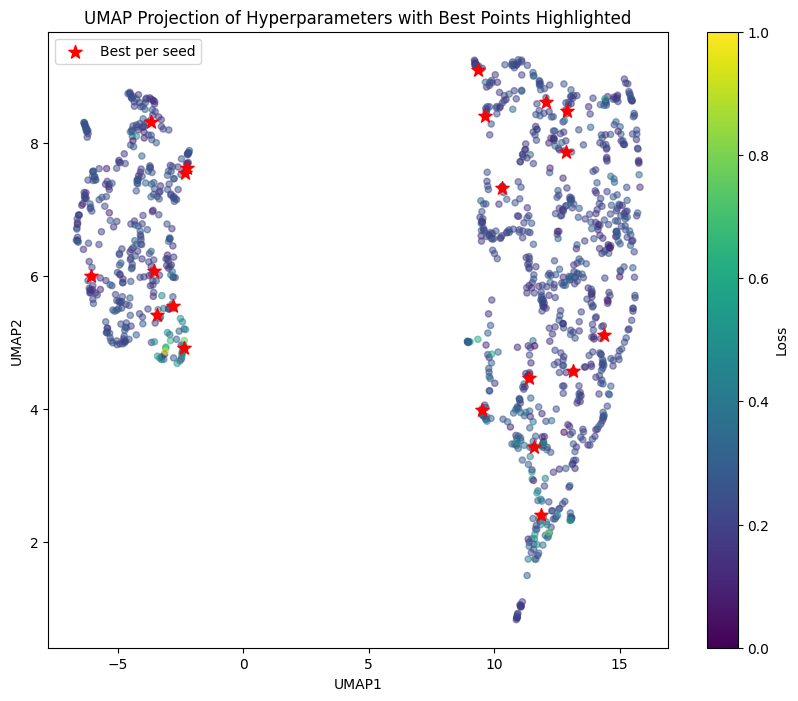

In [69]:
import umap
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

param_cols = ['latent_dim', 'hidden_dim_factor', 'lr', 'supervisor_hidden_dim', 'batch_size']

# 标准化
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df[param_cols])

# UMAP降到2维
reducer = umap.UMAP(n_components=2, random_state=42)
embedding = reducer.fit_transform(X_scaled)

# 把embedding加入df
df['UMAP1'] = embedding[:, 0]
df['UMAP2'] = embedding[:, 1]

# 找每个seed最低loss点
best_rows = df.loc[df.groupby('seed')['loss'].idxmin()]

# 画图
plt.figure(figsize=(10, 8))
# 所有点，颜色按loss
plt.scatter(df['UMAP1'], df['UMAP2'], c=df['loss'], cmap='viridis', alpha=0.5, s=20)
# 最低点，红色大点
plt.scatter(best_rows['UMAP1'], best_rows['UMAP2'], color='red', s=100, marker='*', label='Best per seed')

plt.colorbar(label='Loss')
plt.title('UMAP Projection of Hyperparameters with Best Points Highlighted')
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')
plt.legend()
plt.show()


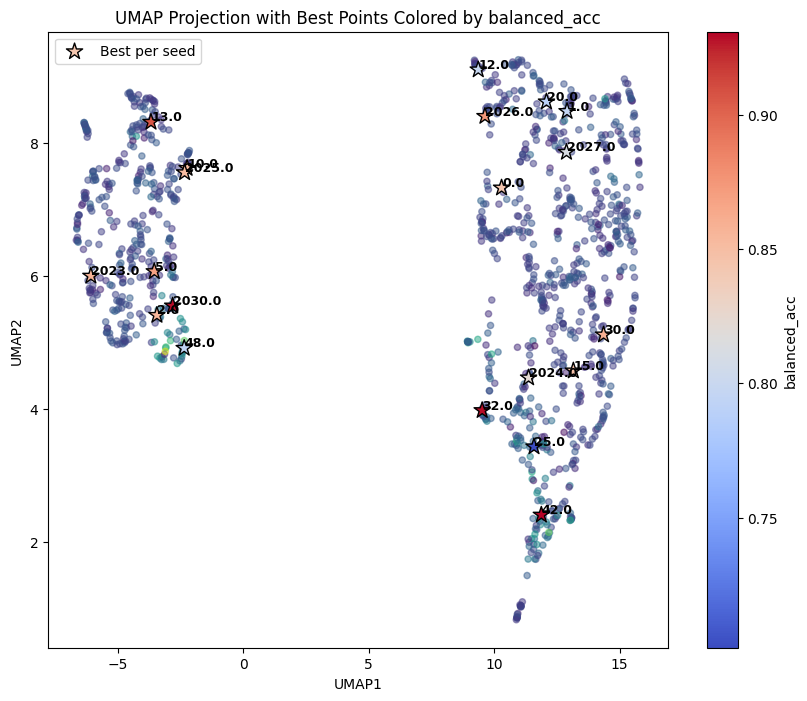

In [73]:
import matplotlib.pyplot as plt

# 假设你想用的指标名，比如 'average_aupr'
metric_name = 'balanced_acc'
# 可用的指标名示例：
# 'average_aupr'    # 平均精确率-召回率曲线下面积
# 'average_auroc'   # 平均ROC曲线下面积
# 'balanced_acc'    # 平衡准确率
# 'f1_score'        # F1分数（调和平均的精准率和召回率）
# 'kappa'           # Cohen's Kappa，一致性指标
# 'precision'       # 精准率
# 'recall'          # 召回率

# 把df_metrics的索引转换成列方便合并
df_metrics_reset = df_metrics.reset_index()

# 只取test_size=0.3这部分（如果你有多test_size要过滤）
df_metrics_03 = df_metrics_reset[df_metrics_reset['test_size'] == 0.3]

# 给best_rows合并对应指标
best_with_metrics = best_rows.merge(
    df_metrics_03[['seed', metric_name]],
    on='seed',
    how='left'
)

plt.figure(figsize=(10, 8))

# 所有点，loss颜色
plt.scatter(df['UMAP1'], df['UMAP2'], c=df['loss'], cmap='viridis', alpha=0.5, s=20)

# 用metric的颜色画每个seed最佳点（五角星）
sc = plt.scatter(
    best_with_metrics['UMAP1'], best_with_metrics['UMAP2'],
    c=best_with_metrics[metric_name],
    cmap='coolwarm',
    s=150,
    marker='*',
    edgecolor='k',
    label='Best per seed'
)

# 标注每个最佳点的seed
for _, row in best_with_metrics.iterrows():
    plt.text(row['UMAP1']+0.02, row['UMAP2']+0.02, str(row['seed']),
             fontsize=9, weight='bold', color='black')

plt.colorbar(sc, label=metric_name)
plt.title(f"UMAP Projection with Best Points Colored by {metric_name}")
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')
plt.legend()
plt.show()


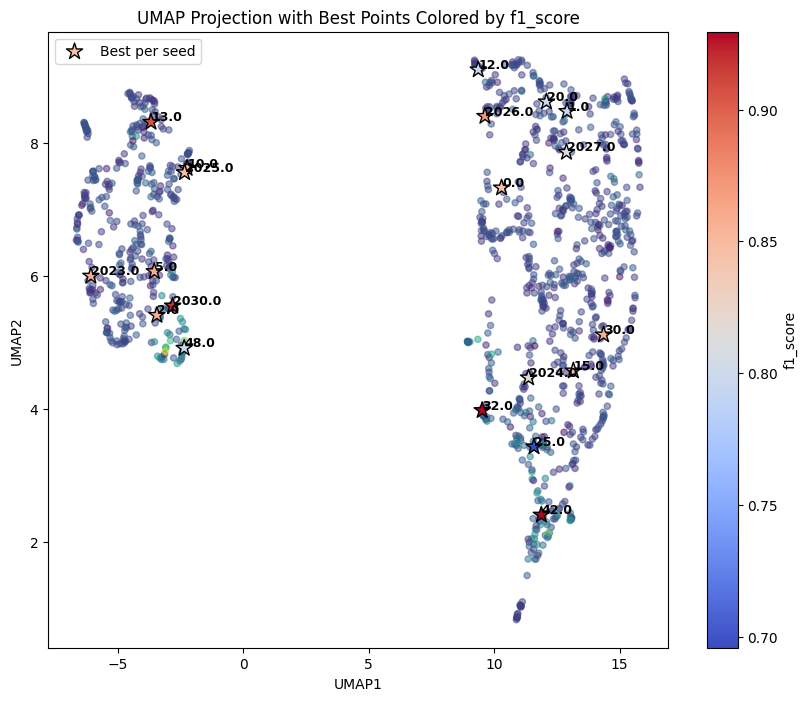

In [75]:
import matplotlib.pyplot as plt

# 假设你想用的指标名，比如 'average_aupr'
metric_name = 'f1_score'
# 可用的指标名示例：
# 'average_aupr'    # 平均精确率-召回率曲线下面积
# 'average_auroc'   # 平均ROC曲线下面积
# 'balanced_acc'    # 平衡准确率
# 'f1_score'        # F1分数（调和平均的精准率和召回率）
# 'kappa'           # Cohen's Kappa，一致性指标
# 'precision'       # 精准率
# 'recall'          # 召回率

# 把df_metrics的索引转换成列方便合并
df_metrics_reset = df_metrics.reset_index()

# 只取test_size=0.3这部分（如果你有多test_size要过滤）
df_metrics_03 = df_metrics_reset[df_metrics_reset['test_size'] == 0.3]

# 给best_rows合并对应指标
best_with_metrics = best_rows.merge(
    df_metrics_03[['seed', metric_name]],
    on='seed',
    how='left'
)

plt.figure(figsize=(10, 8))

# 所有点，loss颜色
plt.scatter(df['UMAP1'], df['UMAP2'], c=df['loss'], cmap='viridis', alpha=0.5, s=20)

# 用metric的颜色画每个seed最佳点（五角星）
sc = plt.scatter(
    best_with_metrics['UMAP1'], best_with_metrics['UMAP2'],
    c=best_with_metrics[metric_name],
    cmap='coolwarm',
    s=150,
    marker='*',
    edgecolor='k',
    label='Best per seed'
)

# 标注每个最佳点的seed
for _, row in best_with_metrics.iterrows():
    plt.text(row['UMAP1']+0.02, row['UMAP2']+0.02, str(row['seed']),
             fontsize=9, weight='bold', color='black')

plt.colorbar(sc, label=metric_name)
plt.title(f"UMAP Projection with Best Points Colored by {metric_name}")
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')
plt.legend()
plt.show()


In [ ]:
# 代码改写

In [89]:
# importance_diff
import os
import json
import pandas as pd
import numpy as np

def extract_feature_importance_diff_df(results_dict, test_size='test_size_0.3', top_k=30):
    seed_dict = results_dict[test_size]

    # 所有种子的 feature importance diff
    feature_names = set()
    seed_importance = {}

    for seed, content in seed_dict.items():
        fi_diff = content['feature_importance_diff']
        seed_importance[seed] = {f['name']: f['importance_diff_abs'] for f in fi_diff}
        feature_names.update(seed_importance[seed].keys())

    feature_names = sorted(feature_names)

    # 筛选 top_k
    if top_k:
        mean_importance = {}
        for feat in feature_names:
            vals = [seed_importance[seed].get(feat, 0) for seed in seed_importance]
            mean_importance[feat] = np.mean(vals)
        feature_names = sorted(mean_importance, key=mean_importance.get, reverse=True)[:top_k]

    # 构造 DataFrame：行是 (seed, feature_name)，列是 importance_diff_abs
    records = []
    for seed, feat_dict in seed_importance.items():
        for feat in feature_names:
            records.append({
                'seed': int(seed.split('_')[-1]),
                'feature_name': feat,
                'importance_diff_abs': feat_dict.get(feat, 0)
            })

    df_plot_data = pd.DataFrame(records)
    return df_plot_data


# 使用例子：生成 & 保存
save_folder = r"C:\Users\laura\OneDrive - Imperial College London\project 2\Coding\New models\package\flexynesis\dataset_DM_stablility_test"
save_path = os.path.join(save_folder, "feature_importance_diff_plot_data.csv")

df_plot = extract_feature_importance_diff_df(results_dict, test_size='test_size_0.3', top_k=30)
df_plot.to_csv(save_path, index=False)

print(f"✅ 成功保存绘图数据：{save_path}")


import pandas as pd
import matplotlib.pyplot as plt

def plot_feature_importance_diff_from_csv(csv_path, top_k=30):
    # 读取保存的 DataFrame
    df = pd.read_csv(csv_path)

    # 只保留 top_k 平均 importance_diff_abs 最大的特征
    top_features = (
        df.groupby("feature_name")["importance_diff_abs"]
        .mean()
        .sort_values(ascending=False)
        .head(top_k)
        .index.tolist()
    )

    df_filtered = df[df["feature_name"].isin(top_features)]

    # 按 seed 分组
    grouped = df_filtered.groupby("seed")

    # 获取 x 轴标签顺序
    x_labels = top_features
    x_indices = range(len(x_labels))

    # 开始绘图
    plt.figure(figsize=(14, 6))
    for seed, group in grouped:
        y_values = [group[group['feature_name'] == feat]['importance_diff_abs'].values[0]
                    if feat in group['feature_name'].values else 0 for feat in x_labels]
        plt.plot(x_indices, y_values, label=f'Seed {seed}', marker='o')

    plt.xticks(ticks=x_indices, labels=x_labels, rotation=45, ha='right')
    plt.xlabel("Feature Name")
    plt.ylabel("Importance Diff (Abs)")
    plt.title("Feature Importance Diff Across Seeds")
    plt.legend()
    plt.tight_layout()
    plt.grid(True)
    plt.show()


# 使用示例
csv_path = r"C:\Users\laura\OneDrive - Imperial College London\project 2\Coding\New models\package\flexynesis\dataset_DM_stablility_test\feature_importance_diff_plot_data.csv"
plot_feature_importance_diff_from_csv(csv_path, top_k=30)


✅ 成功保存绘图数据：C:\Users\laura\OneDrive - Imperial College London\project 2\Coding\New models\package\flexynesis\dataset_DM_stablility_test\feature_importance_diff_plot_data.csv


In [93]:
import pandas as pd
import numpy as np

def get_feature_importance_diff_df(results_dict, test_size='test_size_0.3', top_k=30):
    seed_dict = results_dict[test_size]

    feature_names = set()
    seed_importance = {}

    for seed, content in seed_dict.items():
        fi_diff = content['feature_importance_diff']
        seed_importance[seed] = {f['name']: f['importance_diff_abs'] for f in fi_diff}
        feature_names.update(seed_importance[seed].keys())

    feature_names = sorted(feature_names)

    # 计算 top_k（按平均importance）
    if top_k:
        mean_importance = {
            feat: np.mean([seed_importance[seed].get(feat, 0) for seed in seed_importance])
            for feat in feature_names
        }
        feature_names = sorted(mean_importance, key=mean_importance.get, reverse=True)[:top_k]

    # 构造 DataFrame：行是 feature_name，列是 seed
    records = []
    for feat in feature_names:
        row = {"feature_name": feat}
        for seed in seed_importance:
            row[f"seed_{seed}"] = seed_importance[seed].get(feat, 0)
        records.append(row)

    df_diff = pd.DataFrame(records)
    df_diff.set_index("feature_name", inplace=True)

    return df_diff
save_path = r"C:\Users\laura\OneDrive - Imperial College London\project 2\Coding\New models\package\flexynesis\dataset_DM_stablility_test\feature_importance_diff_plot_data.csv"
df_diff = get_feature_importance_diff_df(results_dict, test_size='test_size_0.3', top_k=30)
df_diff.to_csv(save_path)
print(f"✅ 成功保存：{save_path}")


✅ 成功保存：C:\Users\laura\OneDrive - Imperial College London\project 2\Coding\New models\package\flexynesis\dataset_DM_stablility_test\feature_importance_diff_plot_data.csv
